Imran Muhammad, Olga Kellert, and Carlos Gómez-Rodríguez. "A Syntax-Injected Approach for Faster and More Accurate Sentiment Analysis." arXiv preprint arXiv:2406.15163 (2024). The preprint version is available on arXiv: URL: https://arxiv.org/html/2406.15163v1

In [1]:
from utilities import *
import transformers
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

from src.models.deps_tree import D_Tree
from src.models.deps_label import D_Label
from src.utils.constants import D_ROOT_HEAD, D_NULLHEAD, D_ROOT_REL, D_POSROOT, D_EMPTYREL, D_2P_GREED, D_2P_PROP
from src.encs.enc_deps import *
from src.utils.constants import *
from src.models.linearized_tree import LinearizedTree

2024-06-27 12:24:14.614296: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 12:24:14.653012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 12:24:15.536276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import io
import spacy
import os
import time
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
from statistics import mean

import stanza

In [4]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,mwt,lemma,depparse')

2024-06-27 12:24:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-27 12:24:16 WARNING: Can not find mwt: default from official model list. Ignoring it.
2024-06-27 12:24:17 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2024-06-27 12:24:17 INFO: Using device: cuda
2024-06-27 12:24:17 INFO: Loading: tokenize
2024-06-27 12:24:17 INFO: Loading: pos
2024-06-27 12:24:17 INFO: Loading: lemma
2024-06-27 12:24:17 INFO: Loading: depparse
2024-06-27 12:24:17 INFO: Done loading processors!


### Configurations

In [7]:
Dict = "Dict1" #Options ["Dict1", "Dict2", "Dict3", "Dict4"]
mode = "Stanza" #Options ["Model", "Stanza"]

In [8]:
def populateDict(filename):
    dic = {}
    encodings = ['utf-8', 'latin-1', 'cp1252']
    for encoding in encodings:
        try:
            with open(filename, 'r', encoding=encoding) as file:
                for line in file:
                    try:
                        word, value = line.strip().split('\t')
                        dic[word] = float(value)
                    except ValueError:
                        print("Error parsing line:", line)
            return dic
        except UnicodeDecodeError:
            print(f"Failed to decode using {encoding} encoding")
    print("Failed to decode the file using any of the specified encodings")
    return None

In [9]:
# SO-CAL (English)
if(Dict == "Dict1"):
    dAdj = populateDict('../sentiment-dictionaries/english/so-cal/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/english/so-cal/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/english/so-cal/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/english/so-cal/verb.txt')

# Vader Only
elif(Dict == "Dict2"):
    dAdj = populateDict('../sentiment-dictionaries/english/vader-only/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/english/vader-only/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/english/vader-only/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/english/vader-only/verb.txt')

# Merged (SO-CAL + Vader) Dictionaries
elif(Dict == "Dict3"):
    dAdj = populateDict('../sentiment-dictionaries/english/vader/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/english/vader/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/english/vader/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/english/vader/verb.txt')

# Merged (SO-CAL + Vader + Senticwordnet) Dictionaries
elif(Dict == "Dict4"):
    dAdj = populateDict('../sentiment-dictionaries/english/senticwordnet/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/english/senticwordnet/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/english/senticwordnet/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/english/senticwordnet/verb.txt')

# Sentdicts
sentdicts={"ADV": dAdv, "ADJ": dAdj, "NOUN": dNoun, "VERB": dVerb}

In [13]:
lstNeg = ['not', 'nor', 'seldom', 'arent', "won't", 'rarely', "doesn't", 'barely', 'mustnt', "hadn't",
        "don't", 'isnt', 'nowhere', 'cannot', 'doesnt', "couldn't", 'oughtnt', 'couldnt', "haven't",
        'never', 'no_one', "ain't", 'despite', "daren't", 'without', 'uhuh', 'scarcely', 'nope',
        'wouldnt', 'neither', "mustn't", 'nothing', "needn't", 'dont', "isn't", "shouldn't",
        'uh-uh', 'wasnt', 'neednt', 'werent', "oughtn't", "wouldn't", 'cant', 'nobody', "hasn't",
        "weren't", "shan't", 'darent', 'shouldnt', 'aint', 'shant', 'hadnt', 'didnt', "mightn't",
        'none', 'wont', "aren't", "can't", "didn't", 'mightnt', 'havent', "wasn't", 'no', 'hardly', 'hasnt']

In [14]:
### Dictionary of modifiers/intensifiers in English
dInt = populateDict('../sentiment-dictionaries/english/intensifiers.txt')

In [15]:
dictionaries = [dAdj, dNoun, dVerb, dAdv] # This code snippet makes sure that intensifiers do not match sentiment words

# Iterate through each dictionary
for d in dictionaries:
    # Iterate through the keys of dInt
    for key in dInt.keys():
        # Check if the key exists in the current dictionary
        if key in d:
            # Delete the entry from the current dictionary
            del d[key]

In [16]:
max(dAdv.values())

5.0

In [17]:
min(dAdv.values())

-5.0

In [18]:
max(dAdj.values())

5.0

In [19]:
min(dAdj.values())

-5.0

In [20]:
if(mode == 'Model'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModelForTokenClassification.from_pretrained("../parsers/models/rel-distilbert-en/model")
elif(mode == "Stanza"):
    pass

In [21]:
# Dependency Parsing with Stanza
def createDic(sent):
    doc = nlp(sent)
    dicts=doc.to_dict()
    return dicts # lists of sentences where each sentence is split into words and each word has a dictionary

# Dependency Parsing with Model
def createDicModel(text, spacy_datas, lang='en'):
    try:
        spacy_lemmas = {}
        dec_tree = ''

        for spacy_data in spacy_datas:
            tokens_with_spacy = spacy_data['tokens']
            if tokens_with_spacy[-1] == '\n':
                tokens_with_spacy = tokens_with_spacy[:-1]

            tokenized_text = pre_tokenized_text(tokens_with_spacy)
            # Example pre-tokenized text/data
            #tokenized_text = ["[CLS]", 'I', 'do', "n't", 'eat', 'very', 'much', 'pieces', 'of', 'chocolate', '.', "[SEP]"]

            # Convert tokens to input IDs using the tokenizer
            input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)

            # Create input tensors
            input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add a batch dimension

            with torch.no_grad():
                #logits = model(**inputs).logits
                logits = model(input_ids).logits

                predictions = torch.argmax(logits, dim=2)
                # Model's predictions/rules
                predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0][1:-1]]

            words = tokens_with_spacy
            postags = spacy_data['postags']
            #print("postags ", postags)
            if postags[-1] == 'SPACE':
                postags = postags[:-1]
            #print(postags)
            labels = []
            for p in predicted_token_class:
                if(p != '[CLS]' and p != '[SEP]'):
                    labels.append(D_Label.from_string(p, sep="_"))
            #print("labels ", labels)
            lin_tree = LinearizedTree(words=words, postags=postags,
                        additional_feats=[], labels=labels, n_feats=0)

            encoder = D_NaiveRelativeEncoding(separator="_", hang_from_root=True)
            dec_tree = encoder.decode(lin_tree)
            dec_tree.postprocess_tree(search_root_strat=D_ROOT_HEAD, allow_multi_roots=False)
            dec_tree = str(dec_tree)
            spacy_lemmas = spacy_data['lemmas']

        return [tree2dic_optim(dec_tree, spacy_lemmas)]
    except Exception as e:
        print("Model Inference Error: " + str(e))

In [26]:
def FilterNonLemmaWords(Sentence): # this function deletes problematic lemmas like Spanish: hacerlo
    FilteredSentence=[word for word in Sentence if 'lemma' in word.keys()]
    return (FilteredSentence)

In [27]:
def CreateDefaultElementType(Sentence): # assigns to each lemma a default element type 'ord'
    for i in range(len(Sentence)):
        Sentence[i]['elementType'] = 'ord'
    return (Sentence)

In [28]:
# Set element score from Sentiment dictionaries
def GetElementScore(Sentence):
    for i in range(len(Sentence)):
        lem = Sentence[i]['lemma']
        upos = Sentence[i]['upos']

        if upos == 'ADJ' and lem in dAdj.keys():
            Sentence[i]['elementScore']=dAdj[lem]
        elif upos == 'ADV' and lem in dAdv.keys():
            Sentence[i]['elementScore']=dAdv[lem]
        elif upos == 'VERB' and lem in dVerb.keys():
            Sentence[i]['elementScore']=dVerb[lem]
        elif upos == 'NOUN' and lem in dNoun.keys():
            Sentence[i]['elementScore']=dNoun[lem]
        else:
            Sentence[i]['elementScore']='none'
    return Sentence

In [29]:
def InitializeSentimentScore(Sentence): # default is a Sentiment Score
    for i in range(len(Sentence)):
        Sentence[i]['SentimentScore']='none'
    return Sentence

In [30]:
### Creating dctChild dictionary: key= headid, value= a list of childrenids
def getChildParentDicts(dct):
    dctChild       = {}
    dctParent      = {}
    dctBeforeToken = {}

    for dicVal in dct:
        elementID          = dicVal['id']
        elementHead        = dicVal['head']
        elementLemma       = dicVal['lemma']

        if(elementID != 1 ):
            eleBeforeDic = dct[int(elementID)-2]
            elementBeforLemma = eleBeforeDic['lemma']
        else:
            elementBeforLemma = "-"

        # dic parent is done
        dctParent[elementID] = elementHead
        dctBeforeToken[elementLemma] =elementBeforLemma

        if elementHead not in dctChild.keys():
            dctChild[elementHead] =[]

        # Adding to the parent node (Elements and ElementsLemma)
        dctChild[elementHead].append(elementID)

    # Sibling dictionary
    dctSibling = {}

    # Giving some default values
    for key in dctParent.keys():
        dctSibling[key]=[]
    for key in dctChild.keys():
        childList = dctChild[key]
        for chld in childList:
            dctSibling[chld] = [x for x in childList if x != chld]
    return dctChild, dctParent, dctSibling, dctBeforeToken

In [31]:
#### definining the ORDER of key-value pairs from dctChild, which equal tree branches in a dependency tree. The order follows from branches at the bottom that are simple branches (sb) to complex branches (cb), e.g. [a [very good]-sb service]-cb
def calcbranchorder(dctChild):
    if list(dctChild.keys())==[0]:
        calcheads=[0]
    else:
        allheads=list(dctChild.keys())
        calcheads=[]
        children=dctChild[0]
        nextchildren=[]
        numchildren=len(children)
        while numchildren > 0:
            nextchildren=[]
            for child in children:
                if child in allheads:
                    calcheads.append(child)
                    nextchildren = nextchildren + dctChild[child]
            children=nextchildren
            numchildren=len(children)
        calcheads.reverse()
    return calcheads

In [32]:
# deal with conjunction
# this code snippet is a definition that takes a list of word dictionaries (=dct) and spits out a modified dct with updated elementScore that depends on sentiment words being modified by elements like intensification, negation, adversative modifiers.

from pickle import TRUE
def calcbranch(dct, headId,childIds):
    # dct is a list of word dictionaries like Sentence
    lstchildren=[dct[childId-1]["text"] + "({},{})".format(childId, dct[childId-1]["deprel"]) for childId in childIds]
    print("head: {}({}), children: {}".format(dct[headId-1]["text"], headId, lstchildren) )

    # finding relevant elements in each branch
    a=0
    b=0
    c=0 # new 3.6.
    neg=0
    p=0
    pvalue=0.25
    negvalue=-4
    Negstat=False
    fmodstat=False
    lexmodstat=False
    conjmodstat=False # new 3.6.
    lexstat=False
    lstcntchildren=[]
    lstmodification=[]
    lstnegation=[]
    PrintList=[]

    # create default outputs
    HeadOutput=[]
    NegOutput=[]
    ModOutput=[]

    # starting with children of the branch
    PrintList.append('Number of Children: {}'.format(len(childIds)))
    for i in range(len(childIds)):
        childId=childIds[i]
        lemma=dct[childId-1]["lemma"]
        text=dct[childId-1]["text"]
        pos=dct[childId-1]["upos"]#
        deprel=dct[childId-1]["deprel"] # head, amod, nmod, mod in deprel
        elementScore=dct[childId-1]["elementScore"]
        if dct[childId-1]["SentimentScore"]!='none':
            SentimentScore=dct[childId-1]["SentimentScore"]
        else:
            SentimentScore=elementScore

        if (lemma in lstNeg or text in lstNeg): # find negation
            # Child cannot be a head
            Negstat=True
            neg=negvalue
            lstchildren[i]=lstchildren[i] + "({})".format("N")
            dct[childId-1]['elementType']='neg'
            #print("negation token is: ", text, "negation childid is: ", childId, "the negation value is: ", neg) #information for the demo
            PrintList.append("Child{}: '{}'({}), Neg={}".format(i, text, childId, neg)) # important for the demo
            NegOutput=[text,neg]
        elif lemma in dInt.keys() and ('mod' in deprel or 'det' in deprel):  #find intensification.
            #Child cannot be a head
            fmodstat = True
            PrevExists=(childId-2) >= 0
            NextExists=childId <= len(dct)-1
            if PrevExists:
                PrevIsInt=dct[childId - 2]["lemma"] in dInt.keys()
                PrevIsNeg=dct[childId - 2]["lemma"] in lstNeg
                PrevIsHead=dct[childId - 2]["head"]==dct[childId-1]["id"]
            else:
                PrevIsInt=False
                PrevIsNeg=False
                PrevIsHead=False
            if NextExists:
                NextIsInt=dct[childId]["lemma"] in dInt.keys()
            else:
                NextIsInt=False
            if PrevIsInt==False and NextIsInt==False: # single intensifier found, e.g. a VERY good service
                if PrevIsNeg and PrevIsHead: # looking for head negation of a single intensifier, e.g. not many problems (Stanza analyses not as a head of many)
                    if dInt[lemma] >0:
                        b= -abs(dInt[lemma])
                    if dInt[lemma] <0:
                        b = abs(dInt[lemma])
                else:
                    b = dInt[lemma]

                PrintList.append("single modifier={}({}), b={}".format(text, childId, b))
                PrintList.append("Child{}: '{}'({}), 1b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(1b={})".format(b)
                ModOutput=[text,b]
            elif PrevIsInt: #double modifier found, e.g. little bit, very small, etc.
                lemma2=dct[childId - 2]["lemma"]
                fmodscore=dInt[lemma]*(1+dInt[lemma2]) # a compound b or 2b
                b=fmodscore
                #print("double modifier is:", text, "childid is: ", childId, "the value of double modifier is: ",  b) ###new 22.5
                PrintList.append("double modifier={}({}), b={}".format(text, childId, b)) ###new 23.5, double modifier
                PrintList.append("Child{}: '{}'({}), 2b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(2b={})".format(b)
                ModOutput=["{}, {}".format(dct[childId - 2]["text"], text), b]
            else:
                PrintList.append("Child{}: '{}'({}), first part of 2b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(2b={})".format(b)
        elif (lemma in sentdicts.keys() or SentimentScore!='none') and 'cl' not in deprel and 'conj' not in deprel: #new update on 3.6= children are neither adj, verbs, nouns or adverbs, but pronouns with a SentimenSscore
            lexmodstat=True
            a=SentimentScore
            lstchildren[i]=lstchildren[i] + "(a={})".format(SentimentScore)
              #PrintList.append("Child{}: '{}'({}), elementScore={}, SentimentScore, a={}".format(i, text, childId, elementScore, SentimentScore))
        elif (lemma in sentdicts.keys() or SentimentScore!='none') and ('cl' in deprel or 'conj' in deprel):  # new update on 3.6.
            conjmodstat=True
            c=SentimentScore
            lstchildren[i]=lstchildren[i] + "(c={})".format(SentimentScore)
        elif lemma in ['but', 'although', 'however', 'nevertheless', 'nonetheless']:
            ### Child cannot be a head. ###
            p=pvalue
            lstchildren[i]=lstchildren[i] + "(p={})".format(p)
            #print("but is present and has the value of: ", p) # for the demo
            #PrintList.append("{} is present, p=".format(lemma, p)) # for the demo
            PrintList.append("Child{}: '{}'({}), p={}".format(i, text, childId, p))
        else:
            lstchildren[i]=lstchildren[i] + "({}={})".format(pos,SentimentScore)
            PrintList.append("Child{}: '{}'({})".format(i, text, childId))
        #print("child: ", childId, text, elementScore)
    PrintList.append("Children-derived score elements: a={}, c={}, b={}, neg={}, p={}".format(a, c, b, neg, p))

    #continuing with parents/heads of the branch
    lemma=dct[headId-1]["lemma"]
    pos=dct[headId-1]["upos"]
    deprel= dct[headId-1]["deprel"]
    text= dct[headId-1]["text"]
    headmodstat= "mod" in deprel
    headscore="none"
    headsentimentscore='none'
    childp=p
    head_a=0
    head_b=0
    head_neg=0
    head_p=0
    calc_a, calc_b, calc_neg, calc_p = 0, 0, 0, 0
    words_to_match = ["bit", "lot", "bunch"]
    lstheads=[]

    if lemma== "nothing":
        head_neg=negvalue
        headsentimentscore=(a * (1+b)  + (np.sign(a*(1+b)))* head_neg)*(1+p)
        dct[headId-1]["SentimentScore"]= headsentimentscore #new
        PrintList.append("Head: '{}'({}), 'nothing'={}, SentimentScore={}".format(text, headId, head_neg, headsentimentscore))
        lstheads.append([text,head_neg, headsentimentscore])
    elif lemma in words_to_match and pos == "NOUN":
        fmodscore= dInt[lemma]
        head_b=fmodscore
        fmodstat=True
        if True:
            headsentimentscore=(a * (1+head_b)  + (np.sign(a*(1+head_b)))* neg)*(1+p)
            dct[headId-1]["SentimentScore"]= headsentimentscore
            PrintList.append("Head: '{}'({}), head intensifier, b={}, SentimentScore={}".format(text, headId, head_b, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, headsentimentscore))
            calc_a, calc_b, calc_neg, calc_p = a, head_b, neg, p
    elif lexmodstat and conjmodstat: # if one of the children is a lexical head, then do the calculation of headsentimentscore.
        if True:
            calc_a, calc_b, calc_neg, calc_p = a, b, neg, p
            headsentimentscore=np.mean([((a * (1+b)  + (np.sign(a*(1+b)))* neg)*(1+p)), c])
            dct[headId-1]["SentimentScore"]= headsentimentscore # the head gets the polarity score of the child
            PrintList.append("Head: '{}'({}), child is a sentiment word with a conjunction, a={},c={}, SentimentScore={}".format(text, headId, a, c, headsentimentscore)) # 25.5.
            #PrintList.append("Head inheriting Childfeatures: '{}'({}), childsentimentscore={}, SentimentScore={}".format(text, headId, childsentimentscore, headsentimentscore)) # 26.5.
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, a, headsentimentscore))
    elif lexmodstat and conjmodstat!=True: # if one of the children is a lexical head, then do the calculation of headsentimentscore.
        if True:
            calc_a, calc_b, calc_neg, calc_p = a, b, neg, p
            headsentimentscore=(a * (1+b)  + (np.sign(a*(1+b)))* neg)*(1+p)
            dct[headId-1]["SentimentScore"]= headsentimentscore # the head gets the polarity score of the child
            PrintList.append("Head: '{}'({}), child is a sentiment word, a={}, SentimentScore={}".format(text, headId, a, headsentimentscore)) # 25.5.
            #PrintList.append("Head inheriting Childfeatures: '{}'({}), childsentimentscore={}, SentimentScore={}".format(text, headId, childsentimentscore, headsentimentscore)) # 26.5.
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, a, headsentimentscore))
    elif pos in sentdicts.keys() and conjmodstat!=True: #only processes if lexmodstat (=child has a sentimentscore) is not satisfied
        dsent= sentdicts[pos]
        if lemma in dsent.keys():
            headscore=dsent[lemma]
            head_a=dsent[lemma]
            headsentimentscore=(head_a * (1+b)  + (np.sign(head_a*(1+b)))* neg)*(1+p)
            PrintList.append("Head: '{}'({}), head is a sentiment word, head_a={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
    elif pos in sentdicts.keys() and conjmodstat: # only processes if lexmodstat (=child has a sentimentscore) is not satisfied
        dsent= sentdicts[pos]
        if lemma in dsent.keys(): #or SentimentScore!='none':
            headscore=dsent[lemma]
            head_a=dsent[lemma]
            headsentimentscore=np.mean([((head_a * (1+b)  + (np.sign(head_a*(1+b)))* neg)*(1+p)), c])
            PrintList.append("Head: '{}'({}), head is a sentiment word with a conjunction head, head_a={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
        else: # only processes if lexmodstat (=child has a sentimentscore) is not satisfied
            headsentimentscore=c
            PrintList.append("Head: '{}'({}), head has no sentiment word with a conjunction head, c={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, c, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
    else:
        PrintList.append("Head: '{}'({}), No calculation possible, SentimentScore={}".format(text, headId, headsentimentscore))
    PrintList.append("HeadOutput {}".format(HeadOutput))
    return dct, HeadOutput, NegOutput, ModOutput

Compute the Sentence Score

In [33]:
def GetSentenceWords(Sentence): # important for the demo
    #Sentence is a list of word dictionaries
    lstwords=[]
    for word in Sentence:
        lstwords.append(word["text"])
    return (lstwords)

In [34]:
# for one-word sentences

def calcSentenceScore(dct): # dct= Sentence which is a list of word dictionaries and the function takes only one sentence
    lstScores=[]
    lstHeadOutput=[]
    lstModOutput=[]
    lstNegOutput=[]
    PrintList = []
    try:
        dctChild, dctParent, dctSibling, dctBeforeToken = getChildParentDicts(dct)

        ###Step 2 figure out order of nodes
        branchheadIds= calcbranchorder(dctChild)
        PrintList.append("branchheadIds: {}".format(branchheadIds))
        topheadid=branchheadIds[-1]

        ## Step 3 looping over nodes
        PrintList.append('Number of branches: {}'.format(len(branchheadIds)))
        if branchheadIds!=[0]: # calculate branches that have more than one word.
            for BranchIndex in range(len(branchheadIds)): #looping over nodes
                headId = branchheadIds[BranchIndex]
                PrintList.append('Branch{}'.format(BranchIndex))
                PrintList.append("Branch{} = head: '{}', children: {}".format(BranchIndex, dct[headId-1]['text'],[dct[Id-1]["text"] for Id in dctChild[headId]]))
                #dct=calcbranch(dct, headId, dctChild[headId])
                dct, HeadOutput, NegOutput, ModOutput=calcbranch(dct, headId, dctChild[headId])
                #if
                lstHeadOutput.append(HeadOutput)
                lstModOutput.append(ModOutput)
                lstNegOutput.append(NegOutput)\
                
            ###Step 4 collect the scores of branchheadIds
                if headId==topheadid and dct[headId-1]["elementScore"]!="none":
                    lstScores.append(dct[headId-1]["SentimentScore"])
                    #print("lstScores", lstScores)
        else: # calculate branches with only one word
            headId=1 #headId=0, ChildId=[1] dctChildren= {0: [1]}
            #dct=calcbranch(dct, headId, [])
            dct, HeadOutput, NegOutput, ModOutput=calcbranch(dct, headId, [])
            lstHeadOutput.append(HeadOutput)
            lstModOutput.append(ModOutput)
            lstNegOutput.append(NegOutput)
            PrintList.append("SentimentScore:{}".format(dct[headId - 1]["SentimentScore"]))
        ###Step 4 collect the scores of branchheadIds
        if dct[headId - 1]["SentimentScore"]!="none": # dct[headId - 1]["elementScore"] does not exist because it is either none nor some score
            #print("elementScore:{}".format(dct[headId - 1]["elementScore"]))
            PrintList.append("SentimentScore:{}".format(dct[headId - 1]["SentimentScore"]))
            lstScores.append(dct[headId - 1]["SentimentScore"])
            #print("lstScores", lstScores)
        else:
            lstScores.append('none')
    except Exception as e:
        print("calcSentenceScore Error: " + str(e))


    ###Step 5 calculate a sentence score      
    if len(lstScores) != 0 and any([score != 'none' for score in lstScores]):
        SentenceScore = np.mean([float(score) for score in lstScores if score!='none'])
        return SentenceScore, lstHeadOutput, lstModOutput, lstNegOutput
    else:
        return 'none', lstHeadOutput, lstModOutput, lstNegOutput

In [35]:
import os
def calcReviewScore(r, spacy={}):
    SentScores=[]
    ReviewlstHeadOutput=[]
    ReviewlstModOutput=[]
    ReviewlstNegOutput=[]
    
    if mode == 'Stanza':
        Sentences = createDic(r)
    elif mode == 'Model':
        Sentences = createDicModel(r, spacy)
    else:
        print('Wrong mode selection.')

    for i in range(len(Sentences)): ### loop over sentences
#         print("************ sentence {} *************".format(i))
        Sentence=FilterNonLemmaWords(Sentences[i]) #it's filtering sentences that contain words don't have a lemma key
        Sentence=CreateDefaultElementType(Sentence)
        Sentence=GetElementScore(Sentence)
        Sentence=InitializeSentimentScore(Sentence)
#         print("all words: {}".format(GetSentenceWords(Sentence)))
#         print("sentiment words: {}".format(["{}={}".format(word["text"], word["elementScore"]) for word in Sentence if word["elementScore"]!="none"]))
        #SentenceScore= calcSentenceScore(Sentence)
        SentenceScore, lstHeadOutput, lstModOutput, lstNegOutput = calcSentenceScore(Sentence)
        #print("lstHeadOutput: {}".format(lstHeadOutput))
        SentScores.append(SentenceScore)
        ReviewlstHeadOutput= ReviewlstHeadOutput + lstHeadOutput
        ReviewlstNegOutput= ReviewlstNegOutput + lstNegOutput
        ReviewlstModOutput= ReviewlstModOutput + lstModOutput
        #ReviewlstSentimentOutput= ReviewlstSentimentOutput + lstSentimentOutput

#     print("***********************************************")
#     print("Headlist: ", ReviewlstHeadOutput)
#     print("Negationlist: ", ReviewlstNegOutput)
#     print("Modifierlist: ", ReviewlstModOutput)
#     #print("Sentimentwordslist: ", ReviewlstSentimentOutput)
#     print("Sentence scores: ", SentScores)

    if len(SentScores) > 0 and any([score != 'none' for score in SentScores]):
        SentScores = [score for score in SentScores if score!='none']
        reviewScore=np.mean([float(score) for score in SentScores])
    else:
        reviewScore='none'
        #reviewScore=-200
    
    print("The Review Score is ", reviewScore)

    # Save the reviewScore to an Excel file
    return reviewScore

In [46]:
data_file = '../datasets/OpeNERen/opener_en.xlsx'

dfTrain = pd.read_excel(data_file, sheet_name='Sheet1')

file_name = "Tweets_English_" + mode + "_New_Code.xlsx"

In [48]:
print(len(dfTrain))

1743


In [49]:
# Drop rows where "Review" column is empty
dfTrain = dfTrain.dropna(subset=["text"])

In [50]:
print(len(dfTrain))

1743


In [51]:
print(dfTrain.head(3))

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   

                                             sent_id  \
0  opener_en/kaf/hotel/english00192_e3fe22eeb3607...   
1  opener_en/kaf/hotel/english00192_e3fe22eeb3607...   
2  opener_en/kaf/hotel/english00192_e3fe22eeb3607...   

                                                text opinions Unnamed: 4  \
0         Experienced staff and had a memorable stay       []        NaN   
1  India as a country has always fascinated me an...       []        NaN   
2  One of my friends who had been there before wa...       []        NaN   

  Unnamed: 5 Unnamed: 6 Polarity Intensity gold_polarity_label  
0        NaN        NaN      NaN       NaN                 NaN  
1        NaN        NaN      NaN       NaN                 NaN  
2        NaN        NaN      NaN       NaN                 NaN  


In [52]:
import re
def sentence_case(text):
    # Split into sentences. Therefore, find all text that ends
    # with punctuation followed by white space or end of string.
    sentences = re.findall(r'(?:\d+\.\d+|\b[A-Z](?:\.[A-Z])*\b\.?|[^.!?])+[.!?](?:\s|\Z)', text)

    # Capitalize the first letter of each sentence
    sentences = [x[0].upper() + x[1:] for x in sentences]
    #print(sentences)
    # Combine sentences
    return ''.join(sentences)

#add space after punctuation
#text = re.sub(r'(\d+\.\d+|\b[A-Z](?:\.[A-Z])*\b\.?)|([.,;:!?)])\s*', lambda x: x.group(1) or f'{x.group(2)} ', text)

def fix_punctuation(text):
    try:
        text = text.lower()
        text = text.replace('\n', '')
        text = text.strip()
        #add space after punctuation
        text1 = re.sub(r'(\d+\.\d+|\b[A-Z](?:\.[A-Z])*\b\.?)|([.,;:!?)])\s*', lambda x: x.group(1) or f'{x.group(2)} ', text)
        return text1
    except:
        return text

### Remove Emojis From Text

In [1]:
def remove_words_and_emojis(text):
    # Sample list of words/emojis to remove
    words_to_remove = ['$:', '%)', '%-)', '&-:', '&:', "( '}{' )", '(%', "('-:", "(':", '((-:', '(*', '(-%', '(-*', '(-:', '(-:0', '(-:<', '(-:o', '(-:O', '(-:{', '(-:|>*', '(-;', '(-;|', '(8', '(:', '(:0', '(:<', '(:o', '(:O', '(;', '(;<', '(=', '(?:', '(^:', '(^;', '(^;0', '(^;o', '(o:', ")':", ")-':", ')-:', ')-:<', ')-:{', '):', '):<', '):{', ');<', '*)', '*-)', '*-:', '*-;', '*:', '*<|:-)', '*\\0/*', '*^:', ',-:', "---'-;-{@", '--<--<@', '.-:', '..###-:', '..###:', '/-:', '/:', '/:<', '/=', '/^:', '/o:', '0-8', '0-|', '0:)', '0:-)', '0:-3', '0:03', '0;^)', '0_o', '10q', '1337', '143', '1432', '14aa41', '182', '187', '2g2b4g', '2g2bt', '2qt', '3:(', '3:)', '3:-(', '3:-)', '4col', '4q', '5fs', '8)', '8-d', '8-o', '86', '8d', ':###..', ':$', ':&', ":'(", ":')", ":'-(", ":'-)", ':(', ':)', ':*', ':-###..', ':-&', ':-(', ':-)', ':-))', ':-*', ':-,', ':-.', ':-/', ':-<', ':-d', ':-D', ':-o', ':-p', ':-[', ':-\\', ':-c', ':-p', ':-|', ':-||', ':-Þ', ':/', ':3', ':<', ':>', ':?)', ':?c', ':@', ':d', ':D', ':l', ':o', ':p', ':s', ':[', ':\\', ':]', ':^)', ':^*', ':^/', ':^\\', ':^|', ':c', ':c)', ':o)', ':o/', ':o\\', ':o|', ':P', ':{', ':|', ':}', ':Þ', ';)', ';-)', ';-*', ';-]', ';d', ';D', ';]', ';^)', '</3', '<3', '<:', '<:-|', '=)', '=-3', '=-d', '=-D', '=/', '=3', '=d', '=D', '=l', '=\\', '=]', '=p', '=|', '>-:', '>.<', '>:', '>:(', '>:)', '>:-(', '>:-)', '>:/', '>:o', '>:p', '>:[', '>:\\', '>;(', '>;)', '>_>^', '@:', '@>-->--', "@}-;-'---", 'aas', 'aayf', 'afu', 'alol', 'ambw', 'aml', 'atab', 'awol', 'ayc', 'ayor', 'aug-00', 'bfd', 'bfe', 'bff', 'bffn', 'bl', 'bsod', 'btd', 'btdt', 'bz', 'b^d', 'cwot', "d-':", 'd8', 'd:', 'd:<', 'd;', 'd=', 'doa', 'dx', 'ez', 'fav', 'fcol', 'ff', 'ffs', 'fkm', 'foaf', 'ftw', 'fu', 'fubar', 'fwb', 'fyi', 'fysa', 'g1', 'gg', 'gga', 'gigo', 'gj', 'gl', 'gla', 'gn', 'gr8', 'grrr', 'gt', 'h&k', 'hagd', 'hagn', 'hago', 'hak', 'hand', 'heart', 'hearts', 'hho1/2k', 'hhoj', 'hhok', 'hugz', 'hi5', 'idk', 'ijs', 'ilu', 'iluaaf', 'ily', 'ily2', 'iou', 'iyq', 'j/j', 'j/k', 'j/p', 'j/t', 'j/w', 'j4f', 'j4g', 'jho', 'jhomf', 'jj', 'jk', 'jp', 'jt', 'jw', 'jealz', 'k4y', 'kfy', 'kia', 'kk', 'kmuf', 'l', 'l&r', 'laoj', 'lmao', 'lmbao', 'lmfao', 'lmso', 'lol', 'lolz', 'lts', 'ly', 'ly4e', 'lya', 'lyb', 'lyl', 'lylab', 'lylas', 'lylb', 'm8', 'mia', 'mml', 'mofo', 'muah', 'mubar', 'musm', 'mwah', 'n1', 'nbd', 'nbif', 'nfc', 'nfw', 'nh', 'nimby', 'nimjd', 'nimq', 'nimy', 'nitl', 'nme', 'noyb', 'np', 'ntmu', 'o-8', 'o-:', 'o-|', 'o.o', 'O.o', 'o.O', 'o:', 'o:)', 'o:-)', 'o:-3', 'o:3', 'o:<', 'o;^)', 'ok', 'o_o', 'O_o', 'o_O', 'pita', 'pls', 'plz', 'pmbi', 'pmfji', 'pmji', 'po', 'ptl', 'pu', 'qq', 'qt', 'r&r', 'rofl', 'roflmao', 'rotfl', 'rotflmao', 'rotflmfao', 'rotflol', 'rotgl', 'rotglmao', 's:', 'sapfu', 'sete', 'sfete', 'sgtm', 'slap', 'slaw', 'smh', 'snafu', 'sob', 'swak', 'tgif', 'thks', 'thx', 'tia', 'tmi', 'tnx', 'true', 'tx', 'txs', 'ty', 'tyvm', 'urw', 'vbg', 'vbs', 'vip', 'vwd', 'vwp', 'wag', 'wd', 'wilco', 'wp', 'wtf', 'wtg', 'wth', 'x-d', 'x-p', 'xd', 'xlnt', 'xoxo', 'xoxozzz', 'xp', 'xqzt', 'xtc', 'yolo', 'yoyo', 'yvw', 'yw', 'ywia', 'zzz', '[-;', '[:', '[;', '[=', '\\-:', '\\:', '\\:<', '\\=', '\\^:', '\\o/', '\\o:', ']-:', ']:', ']:<', '^<_<', '^urs', '{:', '|-0', '|-:', '|-:>', '|-o', '|:', '|;-)', '|=', '|^:', '|o:', '||-:', '}:', '}:(', '}:)', '}:-(', '}:-)', 'x-d', 'x-p', 'xd', 'xp', 'yay']
    words = text.split()
    neat_words = []
    for word in words:
        if word not in words_to_remove:
            neat_words.append(word)
    return ' '.join(neat_words)

In [2]:
import re

def remove_emojis(text):
    # Define regex pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # Remove emojis from the text
    cleaned_text = emoji_pattern.sub(r'', text)
    return cleaned_text

In [55]:
dfTrain['reviewCorr'] = dfTrain['text'].progress_apply(remove_words_and_emojis)
dfTrain['reviewCorr'] = dfTrain['reviewCorr'].progress_apply(remove_emojis)
dfTrain['reviewCorr'] = dfTrain['reviewCorr'].progress_apply(fix_punctuation)

  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

In [56]:
import string
def is_special_characters(s):
    if len(s) < 5:
        # Get the set of all punctuation characters
        punctuation_chars = set(string.punctuation)

        # Check if all characters in the string are punctuation, special characters, or empty spaces
        for char in s:
            if char not in punctuation_chars and not char.isspace():
                return False
        return True
    return False

# Apply the function to the 'Text' column and create a boolean mask
mask = dfTrain['reviewCorr'].apply(is_special_characters)

# Filter out rows where the mask is True
dfTrain = dfTrain[~mask]

# Reset the index of the filtered DataFrame
dfTrain.reset_index(drop=True, inplace=True)

In [57]:
dfTrain[0:3]

,Unnamed: 0.1,Unnamed: 0,sent_id,text,opinions,Unnamed: 4,Unnamed: 5,Unnamed: 6,Polarity,Intensity,gold_polarity_label,reviewCorr
0,0,0,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,Experienced staff and had a memorable stay,[],NaN,NaN,NaN,NaN,NaN,NaN,experienced staff and had a memorable stay
1,1,1,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,India as a country has always fascinated me an...,[],NaN,NaN,NaN,NaN,NaN,NaN,india as a country has always fascinated me an...
2,2,2,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,One of my friends who had been there before wa...,[],NaN,NaN,NaN,NaN,NaN,NaN,one of my friends who had been there before wa...


In [58]:
dfTrain1= dfTrain

In [59]:
print(len(dfTrain1))

1739


### Remove NaN values

In [60]:
def remove_nan(text):
    return text

In [61]:
if (mode == 'Model'):
    str_list = [*map(remove_nan, dfTrain1['reviewCorr'])]
    clearn_str_list = [x for x in str_list if str(x) != 'nan']
    len(clearn_str_list)

In [62]:
from spacy.language import Language
spacy.prefer_gpu

@Language.component("custom_sentencizer")
def custom_sentencizer(doc):
    for i, token in enumerate(doc[:-2]):
        # Define sentence start if pipe + titlecase token
        if token.text == "\n":
            doc[i + 1].is_sent_start = True
        else:
            # Explicitly set sentence start to False otherwise, to tell
            # the parser to leave those tokens alone
            doc[i + 1].is_sent_start = False
    return doc

In [63]:
print("=== batchSpacy ===")

=== batchSpacy ===


In [64]:
# NLTK
import nltk
from nltk.tokenize import sent_tokenize
# Download the necessary NLTK resources
nltk = nltk.download('punkt')

def tokenize_review_into_sentences_nltk(review, language='english'):
    """
    Tokenizes a review into sentences for the specified language.

    Parameters:
    review (str): The review text to be tokenized.
    language (str): The language of the review text ('english' or 'spanish').

    Returns:
    list: A list of sentences.
    """
    sentences = sent_tokenize(review, language=language)
    # Filter out items that contains puntuations only
    #filtered_sentences = [sentence for sentence in sentences if sentence not in ['.', '?', '!', '. )']]
    filtered_sentences = [sentence for sentence in sentences if len(sentence) > 3]
    return filtered_sentences

def list_to_file(str_list, language='english', tokenize_sentences = True):
    if(tokenize_sentences):
        long_str = ''
        for item in str_list:
            sentences = tokenize_review_into_sentences_nltk(item, language)
            review_str = '\n'.join(sentences)
            review_str = review_str + ' DOC_SEPARATOR \n'
            long_str = long_str + review_str
    else:
        long_str = '\n'.join(str_list)
    file = io.StringIO(long_str)
    return file.read()

def batchSpacySplit(text_data, lang='en'):
    response = []
    try:
        spacy.prefer_gpu()
        if(lang == 'en' or lang == 'english'): 
            nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        elif(lang == 'es' or lang == 'spanish'): 
            nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])
        #nlp.add_pipe("sentencizer")
        config = {"punct_chars": ['\n', 'DOC_SEPARATOR']}
        nlp.add_pipe("sentencizer", config=config)
        #nlp.add_pipe("custom_sentencizer", before="parser")  # Insert before the parser
        nlp.max_length = 1500000000

        #for data_item in text_data:
        response = []
        sentences = []
        doc = nlp(text_data)
        for sent in doc.sents:
            #print("sent.text ", sent.text)
            if sent.text == '\n' or sent.text == '' or sent.text == ' ' or sent.text == '.' or sent.text == '!':
                pass
            else:
                tokens = []
                postags = []
                lemmas = {}
                for token in sent:
                    if(token.text == "DOC_SEPARATOR"):
                        res = {"tokens": tokens, "postags": postags, "lemmas": lemmas}
                        sentences.append(res)
                        response.append(sentences)
                        tokens = []
                        postags = []
                        lemmas = {}
                        sentences = []
                        break # End of Review / Document
                    lemmas.setdefault(token.text, token.lemma_) 
                    tokens.append(token.text)
                    postags.append(token.pos_)
                res = {"tokens": tokens, "postags": postags, "lemmas": lemmas}

                if(len(tokens) > 0):
                    sentences.append(res)
            #response.append(sentences)
    except Exception as error:
        print(error)
    return response

[nltk_data] Downloading package punkt to /home/imran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [65]:
if (mode == 'Model'):
    batch_size = 2000
    
    # Create Batches
    batches = (clearn_str_list[i:i + batch_size] for i in range(0, len(clearn_str_list), batch_size))
    #print(len(batches))
    batch_spacy = []
    count = 0
    for batch in batches:
        count = count + 1
        print(count)
        batch_file_data = list_to_file(batch)
        #print(batch_file_data)
        spacy_single_batch = batchSpacySplit(batch_file_data)
        batch_spacy.extend(spacy_single_batch)

    # Clear Memory Footprint
    del str_list
    del clearn_str_list
    del batches
    
    print(len(batch_spacy))
    print(batch_spacy[0])

In [66]:
t0 = time.time()

# Sentiment Analysis with MEAN Function
for i, row in tqdm(dfTrain1.iterrows()):
    #print(i, row.reviewCorr)
    try:
        if (mode == 'Model'):
            dfTrain1.at[i,'Score'] = calcReviewScore(row.reviewCorr, batch_spacy[i])
        elif(mode == 'Stanza'):
            dfTrain1.at[i,'Score'] = calcReviewScore(row.reviewCorr)
    except Exception as e:
        dfTrain1.at[i,'Score'] = -100
        #dfTrain1.at[i,'ScoreNew'] = -100
        print("calcSentenceScore Error: " + str(e))
        
print("================== Sentiment Analysis Completed ==================")

t1 = time.time()
total = t1-t0
print(mode)
print('Total Time (Seconds): ' + str(total))

0it [00:00, ?it/s]

head: stay(7), children: ['a(5,det)', 'memorable(6,amod)']
head: had(4), children: ['and(3,cc)', 'stay(7,obj)']
head: staff(2), children: ['experienced(1,amod)', 'had(4,conj)']
The Review Score is  3.0
head: it(25), children: ['about(24,case)']
head: there(17), children: ['who(14,nsubj)', 'have(15,aux)', 'been(16,cop)']
head: say(23), children: ['to(22,mark)', 'it(25,obl)']
head: friends(13), children: ['of(11,case)', 'my(12,nmod:poss)', 'there(17,acl:relcl)']
head: things(21), children: ['wonderful(20,amod)', 'say(23,acl)']
head: all(10), children: ['friends(13,nmod)']
head: country(4), children: ['as(2,case)', 'a(3,det)']
head: have(19), children: ['and(9,cc)', 'all(10,nsubj)', 'always(18,advmod)', 'things(21,obj)']
head: india(1), children: ['country(4,nmod)']
head: fascinated(7), children: ['india(1,nsubj)', 'has(5,aux)', 'always(6,advmod)', 'me(8,obj)', 'have(19,conj)', '.(26,punct)']
The Review Score is  4.5
head: time(26), children: ['this(25,det)']
head: there(8), children: ['w

/tmp/ipykernel_298132/1662529039.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'none' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfTrain1.at[i,'Score'] = calcReviewScore(row.reviewCorr)


head: particular(39), children: ['in(38,case)']
head: train(37), children: ['((36,punct)', 'particular(39,nmod)', ')(40,punct)']
head: outside(35), children: ['from(34,case)']
head: wall(17), children: ['on(16,case)']
head: noises(33), children: ['and(30,cc)', 'some(31,nsubj)', 'for(32,case)', 'outside(35,nmod)', 'train(37,appos)']
head: view(15), children: ['with(14,case)', 'wall(17,nmod)']
head: old(29), children: ['being(28,cop)', 'noises(33,conj)']
head: colleagues(22), children: ['of(21,case)']
head: room(13), children: ['view(15,nmod)']
head: mattresses(27), children: ['for(25,case)', 'the(26,det)', 'old(29,acl)']
head: most(20), children: ['colleagues(22,nmod)']
head: had(12), children: ['but(10,cc)', 'i(11,nsubj)', 'room(13,obj)']
head: complaining(24), children: [')(19,punct)', 'most(20,nsubj)', 'were(23,aux)', 'mattresses(27,obl)']
head: quiet(9), children: ['and(6,cc)', 'it(7,nsubj)', 'was(8,cop)', 'had(12,conj)']
head: mattress(4), children: ['in(1,case)', 'my(2,nmod:poss)'

head: wanted(10), children: ['they(9,nsubj)', 'tips(11,obj)']
head: them(5), children: ['of(4,case)']
head: know(8), children: ['wanted(10,ccomp)']
head: lot(3), children: ['a(2,det)', 'them(5,nmod)']
head: let(6), children: ['but(1,cc)', 'lot(3,nsubj)', 'you(7,obj)', 'know(8,xcomp)', '.(12,punct)']
The Review Score is  0.0
head: least(17), children: ['at(16,case)']
head: one(18), children: ['least(17,nmod)']
head: occassion(19), children: ['on(15,case)', 'one(18,nummod)']
head: fighting(14), children: ['in(13,mark)', 'occassion(19,obl)']
head: broke(11), children: ['which(10,nsubj)', 'out(12,compound:prt)', 'fighting(14,advcl)']
head: hotel(9), children: ['at(7,case)', 'the(8,det)']
head: contingent(6), children: ['a(3,det)', 'rody(4,compound)', 'russian(5,amod)', 'hotel(9,nmod)', 'broke(11,acl:relcl)']
head: were(2), children: ['there(1,expl)', 'contingent(6,nsubj)', '.(20,punct)']
The Review Score is  none
head: honeymoon(2), children: ['beautiful(1,amod)']
The Review Score is  4.0


head: staff(12), children: ['tha(11,det)', "'s(13,case)"]
head: services(14), children: ['of(10,case)', 'staff(12,nmod:poss)']
head: quality(9), children: ['and(8,cc)']
head: restaurant(19), children: ['especially(16,advmod)', 'in(17,case)', 'the(18,det)']
head: preciseness(7), children: ['the(6,det)', 'quality(9,conj)', 'services(14,nmod)', ',(15,punct)']
head: stress(5), children: ['to(4,mark)', 'preciseness(7,obj)', 'restaurant(19,obl)']
head: like(3), children: ['we(1,nsubj)', 'would(2,aux)', 'stress(5,xcomp)', '.(20,punct)']
The Review Score is  2.0
head: nights(35), children: ['and(34,cc)']
head: days(33), children: ['all(32,det)', 'nights(35,conj)', 'long(36,amod)']
head: entertained(31), children: ['days(33,obl:tmod)']
head: keep(29), children: ['to(28,mark)', 'us(30,obj)', 'entertained(31,xcomp)']
head: effort(27), children: ['a(25,det)', 'great(26,amod)', 'keep(29,acl)']
head: sabri(21), children: ['and(20,cc)']
head: maryem(19), children: [',(18,punct)']
head: anna(17), chil

head: vegas(30), children: ['in(29,case)']
head: day(27), children: ['from(24,case)', 'a(25,det)', 'whole(26,amod)']
head: shopping(44), children: ['/(43,cc)']
head: spend(28), children: ['day(27,obl)', 'vegas(30,obl)']
head: hotel(47), children: ['in(45,case)', 'the(46,det)']
head: food(42), children: ['on(41,case)', 'shopping(44,conj)']
head: tired(23), children: ['when(19,advmod)', 'we(20,nsubj)', 'were(21,cop)', 'already(22,advmod)', 'spend(28,advcl)']
head: pm(18), children: ['after(16,case)', '11(17,nummod)']
head: spend(40), children: ['to(39,mark)', 'food(42,obl)', 'hotel(47,obl)']
head: good(15), children: ['((13,punct)', 'not(14,advmod)', 'pm(18,obl)', 'tired(23,advcl)', ')(31,punct)']
head: voucher(38), children: ['with(36,case)', 'a(37,det)', 'spend(40,acl)']
head: that(35), children: ['for(34,case)']
head: reservation(12), children: ['our(11,nmod:poss)', 'good(15,parataxis)']
head: compensated(33), children: ['but(32,cc)', 'that(35,obl)', 'voucher(38,obl)']
head: messed(9)

head: bathroom(27), children: ['the(26,det)']
head: room(24), children: ['of(22,case)', 'the(23,det)']
head: room(13), children: ['of(11,case)', 'the(12,det)']
head: great(30), children: ['and(25,cc)', 'bathroom(27,nsubj)', 'was(28,cop)', 'very(29,advmod)']
head: size(21), children: [',(18,punct)', 'the(19,det)', 'big(20,amod)', 'room(24,nmod)']
head: cleanliness(16), children: [',(14,punct)', 'the(15,det)', 'overal(17,amod)']
head: size(10), children: [',(7,punct)', 'the(8,det)', 'generous(9,amod)', 'room(13,nmod)']
head: hotel(6), children: ['in(4,case)', 'the(5,det)']
head: welcome(3), children: ['the(1,det)', 'friendly(2,amod)', 'hotel(6,nmod)', 'size(10,conj)', 'cleanliness(16,conj)', 'size(21,conj)', 'great(30,conj)', '.(31,punct)']
The Review Score is  5.5
head: surrounding(4), children: ['and(3,cc)']
head: lovely(7), children: ['very(6,advmod)']
head: location(2), children: ['the(1,det)', 'surrounding(4,conj)']
head: arranged(8), children: ['location(2,nsubj:pass)', 'is(5,aux:p

head: paris(16), children: ['in(15,case)']
head: room(13), children: ['a(11,det)', 'decent(12,amod)']
head: breakfast(5), children: ['without(4,case)']
head: case(23), children: [',(17,punct)', 'but(18,cc)', 'this(19,nsubj)', 'was(20,cop)', 'not(21,advmod)', 'the(22,det)']
head: get(10), children: ['i(8,nsubj)', 'should(9,aux)', 'room(13,obj)', 'also(14,advmod)', 'paris(16,obl)']
head: €(3), children: ['for(1,case)', '160(2,nummod)', 'breakfast(5,nmod)']
head: believe(7), children: ['€(3,obl)', 'i(6,nsubj)', 'get(10,ccomp)', 'case(23,conj)', '.(24,punct)']
The Review Score is  1.0
head: bathroom(8), children: ['the(7,det)']
head: smaller(11), children: ['and(6,cc)', 'bathroom(8,nsubj)', 'is(9,cop)', 'even(10,advmod)']
head: size(3), children: ['the(1,det)', 'room(2,compound)']
head: unbearable(5), children: ['size(3,nsubj)', 'is(4,cop)', 'smaller(11,conj)', '.(12,punct)']
The Review Score is  -3.0
head: that(31), children: ['for(30,case)']
head: €(29), children: ['some(27,det)', '13(28

head: salad(28), children: ['and(27,cc)']
head: fish(25), children: ['((22,punct)', 'occasional(23,amod)', 'bbq(24,compound)', ')(26,punct)']
head: hotdogs(21), children: [',(20,punct)']
head: burgers(19), children: [',(18,punct)']
head: bar(14), children: ['beach(13,compound)']
head: food(11), children: ['of(10,case)']
head: chips(17), children: ['although(12,mark)', 'bar(14,nsubj)', 'was(15,cop)', 'just(16,advmod)', 'burgers(19,conj)', 'hotdogs(21,conj)', 'fish(25,appos)', 'salad(28,conj)']
head: choice(9), children: ['an(7,det)', 'excellent(8,amod)', 'food(11,nmod)']
head: restaurants(5), children: ['the(2,det)', 'five(3,nummod)', 'free(4,amod)']
head: gave(6), children: [')(1,punct)', 'restaurants(5,nsubj)', 'choice(9,obj)', 'chips(17,advcl)', '.(29,punct)']
The Review Score is  5.0
head: service(6), children: ['and(5,cc)']
head: friendly(4), children: ['very(3,advmod)', 'service(6,conj)']
head: staff(2), children: ['all(1,det)', 'friendly(4,amod)']
head: excellent(8), children: ['

head: motorcycle(32), children: ['on(30,case)', 'my(31,nmod:poss)']
head: enter(45), children: ["'(41,punct)", 'only(42,advmod)', 'they(43,nsubj)', 'could(44,aux)', "'(46,punct)"]
head: shed(40), children: ['in(37,case)', 'a(38,det)', 'bike(39,compound)']
head: damage(29), children: ['for(27,case)', 'serious(28,amod)', 'motorcycle(32,nmod)']
head: put(36), children: ['which(34,nsubj:pass)', 'was(35,aux:pass)', 'shed(40,obl)', 'enter(45,parataxis)']
head: responsible(26), children: ["'(22,punct)", 'also(23,advmod)', 'staaf(24,nsubj)', 'was(25,cop)', 'damage(29,obl)']
head: everything(12), children: ['00(11,nummod)']
head: 22(9), children: ['fron(8,case)']
head: luck(21), children: [';(19,punct)', 'bad(20,amod)', 'responsible(26,parataxis)', ',(33,punct)', 'put(36,acl:relcl)']
head: says(18), children: ['staff(17,nsubj)']
head: quit(15), children: [';(10,punct)', 'everything(12,nsubj:pass)', 'must(13,aux)', 'be(14,aux:pass)']
head: tat(7), children: ['despite(5,case)', 'rule(6,compound)'

head: room(17), children: ['to(14,case)', 'an(15,det)', 'executive(16,amod)']
head: upgraded(13), children: ['and(11,cc)', 'got(12,aux:pass)', 'room(17,obl)']
head: room(10), children: ['a(7,det)', 'standard(8,amod)', 'guest(9,compound)']
head: diamond(4), children: ['as(1,case)', 'a(2,det)', 'hh(3,compound)']
head: booked(6), children: ['diamond(4,obl)', 'i(5,nsubj)', 'room(10,obj)', 'upgraded(13,conj)', '.(18,punct)']
The Review Score is  1.0
head: 70s(9), children: ['in(7,case)', 'the(8,det)']
head: hotel(4), children: ['the(3,det)']
head: build(6), children: ['even(1,advmod)', 'though(2,mark)', 'hotel(4,nsubj)', 'is(5,aux)', '70s(9,obl)']
head: shape(14), children: ['build(6,advcl)', 'everything(10,nsubj)', 'was(11,cop)', 'in(12,case)', 'good(13,amod)', '.(15,punct)']
The Review Score is  3.0
head: room(6), children: ['and(5,cc)']
head: lounge(4), children: [',(2,punct)', 'executive(3,amod)']
head: impression(10), children: ['a(8,det)', 'good(9,amod)']
head: lobby(1), children: ['l

head: safe(18), children: ['it(16,nsubj)', "'s(17,cop)"]
head: feel(15), children: ['as(11,mark)', 'i(12,nsubj)', 'do(13,aux)', 'not(14,advmod)', 'safe(18,ccomp)']
head: night(10), children: ['at(9,case)']
head: rer(7), children: ['the(6,det)']
head: take(5), children: ['i(1,nsubj)', 'personally(2,advmod)', 'will(3,aux)', 'not(4,advmod)', 'rer(7,obj)', 'late(8,advmod)', 'night(10,obl)', 'feel(15,advcl)', '.(19,punct)']
The Review Score is  0.0
head: where(8), children: ['.(6,punct)', 'but(7,cc)']
head: stars(2), children: ['three(1,nummod)']
head: stated(3), children: ['stars(2,nsubj)', '.(4,punct)', '.(5,punct)', 'where(8,conj)', '?(9,punct)']
The Review Score is  none
head: staff(11), children: [':(8,punct)', 'the(9,det)', 'friendly(10,amod)']
head: one(5), children: ['only(4,advmod)']
head: thing(7), children: ['one(5,nummod)', 'great(6,amod)', 'staff(11,appos)']
head: hotel(2), children: ['this(1,det)']
head: has(3), children: ['hotel(2,nsubj)', 'thing(7,obj)', '.(12,punct)']
The R

head: more(31), children: ['even(30,advmod)']
head: hotel(36), children: ['in(33,case)', 'this(34,det)', 'beautiful(35,amod)']
head: time(32), children: ['more(31,amod)']
head: spend(29), children: ['to(28,mark)', 'time(32,obj)', 'hotel(36,obl)']
head: hotel(15), children: ['the(14,det)']
head: want(27), children: ['spend(29,xcomp)']
head: located(17), children: ['where(13,advmod)', 'hotel(15,nsubj:pass)', 'is(16,aux:pass)']
head: surroundings(9), children: ['the(8,det)']
head: makes(25), children: [',(23,punct)', 'which(24,nsubj)', 'you(26,obj)', 'want(27,xcomp)']
head: uninteresting(22), children: ['and(21,cc)']
head: village(12), children: ['as(10,case)', 'the(11,det)', 'located(17,acl:relcl)']
head: visit(7), children: ['to(6,mark)', 'surroundings(9,obj)']
head: car(5), children: ['a(4,det)']
head: small(20), children: ['village(12,obl)', 'is(18,cop)', 'rather(19,advmod)', 'uninteresting(22,conj)', 'makes(25,advcl:relcl)']
head: having(3), children: ['car(5,obj)', 'visit(7,advcl)']

head: yearly(39), children: ['/(38,punct)']
head: summer(37), children: ['yearly(39,amod)']
head: holiday(40), children: ['and(33,cc)', 'its(34,nmod:poss)', 'your(35,nmod:poss)', 'main(36,amod)', 'summer(37,compound)']
head: not(32), children: ['if(31,mark)']
head: tan(26), children: ['a(24,det)', 'guaranteed(25,amod)']
head: recommended(45), children: [',(30,punct)', 'not(32,advcl)', 'holiday(40,obl)', ',(41,punct)', 'i(42,nsubj)', 'wouldn(43,aux)', "'t(44,advmod)", 'it(46,obj)']
head: egypt(29), children: ['to(28,case)']
head: want(23), children: ['if(21,mark)', 'you(22,nsubj)', 'tan(26,obj)']
head: holiday(10), children: ['this(6,nsubj)', 'was(7,cop)', 'a(8,det)', 'cheap(9,amod)']
head: go(27), children: ['so(20,advmod)', 'want(23,advcl)', 'egypt(29,obl)', 'recommended(45,conj)']
head: bank(17), children: ['the(16,det)']
head: say(5), children: ['although(1,mark)', 'i(2,nsubj)', 'wouldn(3,aux)', "'t(4,advmod)", 'holiday(10,ccomp)']
head: break(15), children: ['say(5,advcl)', ',(11,p

head: nothing(10), children: ['and(9,cc)', 'else(11,amod)']
head: bed(8), children: ['for(6,case)', 'a(7,det)', 'nothing(10,conj)']
head: looking(5), children: ['if(2,mark)', 'you(3,nsubj)', "'re(4,aux)", 'bed(8,obl)', ',(12,punct)']
head: possibility(16), children: ['but(1,cc)', 'looking(5,advcl)', 'this(13,nsubj)', 'is(14,cop)', 'a(15,det)', '.(17,punct)']
The Review Score is  none
head: at(23), children: ['least(24,fixed)']
head: key(14), children: ['((13,punct)', ')(15,punct)']
head: night(27), children: ['((22,punct)', 'at(23,advmod)', 'not(25,advmod)', 'at(26,case)', ')(28,punct)']
head: reception(21), children: ['no(20,det)']
head: card(12), children: ['your(10,nmod:poss)', 'room(11,compound)', 'key(14,appos)']
head: in(3), children: ['·(2,punct)']
head: is(18), children: ['and(16,cc)', 'there(17,expl)', 'thus(19,advmod)', 'reception(21,nsubj)', 'night(27,obl)']
head: disclose(9), children: ['which(8,nsubj)', 'card(12,obj)']
head: check(1), children: ['in(3,compound:prt)']
head:

head: staff(5), children: ['amazing(4,amod)']
head: holiday(7), children: ['with(3,case)', 'staff(5,compound)', 'best(6,amod)']
head: hotel(2), children: ['beautiful(1,amod)', 'holiday(7,nmod)']
The Review Score is  3.0
head: expectations(37), children: ['my(36,nmod:poss)']
head: exceeded(35), children: ['and(34,cc)', 'expectations(37,obj)']
head: stayed(32), children: ['i(29,nsubj)', 'have(30,aux)', 'ever(31,advmod)', 'in(33,obl)', 'exceeded(35,conj)']
head: hotel(25), children: ['the(24,det)']
head: nicest(28), children: ['hotel(25,nsubj)', 'is(26,cop)', 'the(27,det)', 'stayed(32,acl:relcl)']
head: choice(23), children: ['of(22,case)']
head: lots(21), children: ['choice(23,nmod)', 'nicest(28,acl:relcl)']
head: view(13), children: ['with(10,case)', 'a(11,det)', 'beautiful(12,amod)']
head: well(8), children: ['really(7,advmod)']
head: was(20), children: ['and(18,cc)', 'there(19,expl)', 'lots(21,nsubj)']
head: tasted(16), children: ['food(15,nsubj)', 'good(17,xcomp)']
head: cleaned(6), 

head: staff(2), children: ['friendly(1,amod)', '.(3,punct)']
The Review Score is  4.0
head: hotel(2), children: ['excellent(1,amod)', '.(3,punct)']
The Review Score is  5.0
head: staff(2), children: ['friendly(1,amod)', '.(3,punct)']
The Review Score is  4.0
head: town(6), children: ['to(5,case)']
head: access(4), children: ['for(3,case)', 'town(6,nmod)']
head: located(2), children: ['well(1,advmod)', 'access(4,obl)', '.(7,punct)']
The Review Score is  1.0
head: location(2), children: ['quiet(1,amod)', '.(3,punct)']
The Review Score is  1.0
head: better(11), children: ['even(10,advmod)']
head: made(8), children: ['which(7,nsubj)', 'it(9,obj)', 'better(11,xcomp)']
head: upgrade(6), children: ['a(3,det)', 'free(4,amod)', 'room(5,compound)', 'made(8,acl:relcl)']
head: given(2), children: ['were(1,aux:pass)', 'upgrade(6,obj)', '!(12,punct)']
The Review Score is  3.0
head: town(7), children: ['the(6,det)']
head: revisiting(5), children: ['if(4,mark)', 'town(7,obj)']
head: stay(2), children:

head: it(8), children: ['on(7,case)']
head: all(10), children: ['at(9,case)']
head: shadows(6), children: ['no(5,det)', 'it(8,nmod)']
head: pool(3), children: ['the(2,det)']
head: has(4), children: ['and(1,cc)', 'pool(3,nsubj)', 'shadows(6,obj)', 'all(10,obl)', '.(11,punct)']
The Review Score is  3.0
head: question(10), children: ['that(7,nsubj)', 'is(8,cop)', 'the(9,det)']
head: inclusive(5), children: ['or(2,cc)', "'(3,punct)", 'all(4,det)', "'(6,punct)"]
head: inclusive(1), children: ['inclusive(5,conj)', 'question(10,acl:relcl)', '?(11,punct)']
The Review Score is  none
head: clean(3), children: ['and(2,cc)']
head: location(9), children: [',(7,punct)', 'nice(8,amod)']
head: lovely(1), children: ['clean(3,conj)']
head: rooms(6), children: ['lovely(1,amod)', ',(4,punct)', 'nice(5,amod)', 'location(9,conj)', '.(10,punct)']
The Review Score is  2.0
head: service(84), children: ['for(82,case)', 'self(83,compound)']
head: charged(81), children: ['service(84,obl)']
head: due(77), children

head: bike(20), children: ['with(18,case)', 'the(19,det)']
head: beach(17), children: ['at(15,case)', 'the(16,det)', 'bike(20,nmod)']
head: nes(9), children: ['of(8,case)']
head: minutes(14), children: ['and(10,cc)', 'you(11,nsubj)', 'are(12,cop)', 'within(13,case)', 'beach(17,nmod)']
head: centre(7), children: ['to(5,case)', 'the(6,det)', 'nes(9,nmod)']
head: close(4), children: ['it(1,nsubj)', 'is(2,cop)', 'really(3,advmod)', 'centre(7,obl)', 'minutes(14,conj)', '.(21,punct)']
The Review Score is  none
head: part(25), children: ['that(24,det)']
head: tiles(16), children: ['between(14,case)', 'some(15,det)']
head: rated(23), children: ['we(22,nsubj)', 'part(25,obj)', 'lower(26,xcomp)']
head: mold(13), children: ['tiles(16,nmod)']
head: bathroom(11), children: ['the(10,det)']
head: why(21), children: [',(17,punct)', 'so(18,advmod)', 'that(19,nsubj)', "'s(20,cop)", 'rated(23,advcl:relcl)']
head: had(12), children: ['and(9,cc)', 'bathroom(11,nsubj)', 'mold(13,obj)']
head: expected(8), ch

head: hotel(5), children: ['the(4,det)']
head: rebuilding(3), children: ['they(1,nsubj)', 'are(2,aux)', 'hotel(5,obj)', '.(6,punct)']
The Review Score is  none
head: perfect(3), children: ['location(1,nsubj)', 'is(2,cop)', '.(4,punct)']
The Review Score is  5.0
head: highway(6), children: ['and(4,cc)', 'the(5,det)']
head: amsterdam(3), children: ['to(2,case)', 'highway(6,conj)']
head: close(1), children: ['amsterdam(3,obl)', '.(7,punct)']
The Review Score is  none
head: builders(17), children: ['of(15,case)', 'the(16,det)']
head: dirt(14), children: ['and(13,cc)']
head: noise(12), children: [',(11,punct)']
head: because(7), children: ['of(8,fixed)']
head: rebuilding(10), children: ['because(7,case)', 'the(9,det)', 'noise(12,conj)', 'dirt(14,conj)', 'builders(17,nmod)']
head: hotel(5), children: ['the(4,det)']
head: recommend(3), children: ['do(1,aux)', 'not(2,advmod)', 'hotel(5,obj)', 'yet(6,advmod)', 'rebuilding(10,obl)', '.(18,punct)']
The Review Score is  3.0
head: strip(6), childre

head: great(39), children: ['which(35,nsubj)', 'was(38,cop)']
head: amp(31), children: ['&(30,cc)']
head: petros(9), children: ['and(8,cc)']
head: thought(37), children: ['((34,punct)', 'we(36,nsubj)', 'great(39,ccomp)', ')(40,punct)']
head: center(29), children: ['to(26,case)', 'the(27,det)', 'town(28,compound)', 'amp(31,conj)']
head: nadia(7), children: ['petros(9,conj)']
head: bars(33), children: [';(32,punct)', 'thought(37,acl:relcl)']
head: ride(25), children: ['and(21,cc)', 'a(22,det)', 'short(23,amod)', 'taxi(24,compound)', 'center(29,nmod)']
head: cleaned(19), children: ['daily(20,advmod)']
head: apartment(18), children: [',(16,punct)', 'nice(17,amod)']
head: food(15), children: [',(13,punct)', 'great(14,amod)']
head: top(11), children: ['((6,punct)', 'nadia(7,nsubj)', 'are(10,cop)', ')(12,punct)']
head: staff(5), children: [':(3,punct)', 'great(4,amod)', 'top(11,parataxis)', 'food(15,conj)', 'apartment(18,conj)', 'cleaned(19,conj)', 'ride(25,conj)', 'bars(33,conj)']
head: high

head: hot(4), children: ['food(1,nsubj)', 'was(2,cop)', 'always(3,advmod)', 'too(5,advmod)', '.(6,punct)']
The Review Score is  1.5
head: us(3), children: ['of(2,case)']
head: belly(7), children: ['with(5,case)', 'delly(6,compound)']
head: neither(1), children: ['us(3,nmod)']
head: suffered(4), children: ['neither(1,nsubj)', 'belly(7,obl)', '!(8,punct)']
The Review Score is  2.0
head: helpful(5), children: ['and(4,cc)']
head: friendly(3), children: ['staff(1,nsubj)', 'were(2,cop)', 'helpful(5,conj)', '.(6,punct)']
The Review Score is  3.0
head: sunbed(15), children: ['a(14,det)']
head: get(13), children: ['to(12,mark)', 'sunbed(15,obj)']
head: get(9), children: ['to(8,mark)', 'there(10,advmod)', 'early(11,advmod)', 'get(13,advcl)']
head: had(7), children: ['and(6,cc)', 'get(9,xcomp)']
head: beach(2), children: ['the(1,det)']
head: busy(5), children: ['beach(2,nsubj)', 'was(3,cop)', 'always(4,advmod)', 'had(7,conj)', '.(16,punct)']
The Review Score is  -1.0
head: gym(12), children: ['th

head: hotel(2), children: ['dorint(1,amod)']
The Review Score is  none
head: rooms(23), children: ['the(22,det)']
head: lobby(13), children: ['the(12,det)']
head: lovely(10), children: ['where(9,advmod)']
head: room(37), children: ['from(36,case)']
head: centre(29), children: ['köln(27,compound)', 'city(28,compound)']
head: comfortable(25), children: ['and(21,cc)', 'rooms(23,nsubj)', 'very(24,advmod)']
head: hotel(16), children: ['lobby(13,nsubj)', 'was(14,cop)', 'welcoming(15,amod)']
head: staff(8), children: [',(7,punct)', 'lovely(10,amod)']
head: walk(35), children: ['centre(29,nsubj)', 'is(30,cop)', 'only(31,advmod)', 'a(32,det)', 'short(33,amod)', 'scenic(34,amod)', 'room(37,nmod)']
head: condition(20), children: [',(11,punct)', 'hotel(16,nsubj)', 'was(17,cop)', 'in(18,case)', 'great(19,amod)', 'comfortable(25,conj)']
head: hotel(6), children: ['to(4,case)', 'this(5,det)', 'staff(8,appos)']
head: return(3), children: ['will(1,aux)', 'defiantly(2,advmod)', 'hotel(6,obl)', 'conditio

head: cuisine(5), children: ['excellent(4,amod)']
head: hotel(2), children: ['nice(1,amod)', ',(3,punct)', 'cuisine(5,conj)']
The Review Score is  3.5
head: clean(3), children: ['and(2,cc)']
head: nice(1), children: ['clean(3,conj)']
head: hotel(4), children: ['nice(1,amod)', '.(5,punct)']
The Review Score is  2.0
head: toilet(7), children: ['the(6,det)']
head: arrived(5), children: ['when(3,advmod)', 'we(4,nsubj)']
head: day(2), children: ['first(1,amod)']
head: clean(9), children: ['day(2,obl:tmod)', 'arrived(5,advcl)', 'toilet(7,nsubj)', 'wasnt(8,cop)', '.(10,punct)']
The Review Score is  -3.0
head: this(16), children: ['with(15,case)']
head: stay(10), children: ['of(8,case)', 'our(9,nmod:poss)']
head: problem(14), children: ['no(13,det)', 'this(16,nmod)']
head: rest(7), children: ['stay(10,nmod)']
head: had(12), children: ['and(6,cc)', 'rest(7,obl:tmod)', 'we(11,nsubj)', 'problem(14,obj)']
head: day(2), children: ['second(1,amod)']
head: cleaned(5), children: ['day(2,nsubj)', 'was(

head: decoration(12), children: ['with(10,case)', 'tasteful(11,amod)']
head: modern(8), children: ['very(7,advmod)']
head: tower(4), children: ['the(1,det)', 'eurostars(2,compound)', 'madrid(3,compound)']
head: hotel(9), children: ['tower(4,nsubj)', 'is(5,cop)', 'a(6,det)', 'modern(8,amod)', 'decoration(12,nmod)', '.(13,punct)']
The Review Score is  1.0
head: expected(8), children: ['as(7,mark)']
head: luxurious(6), children: ['and(5,cc)']
head: room(2), children: ['the(1,det)']
head: big(4), children: ['room(2,nsubj)', 'was(3,cop)', 'luxurious(6,conj)', 'expected(8,advcl)', '.(9,punct)']
The Review Score is  4.0
head: floors(12), children: ['on(9,case)', 'the(10,det)', 'top(11,amod)']
head: get(7), children: ['to(6,mark)', 'one(8,obj)', 'floors(12,obl)']
head: try(5), children: ['you(4,nsubj)', 'get(7,xcomp)']
head: recommend(3), children: ['i(1,nsubj)', "'d(2,aux)", 'try(5,ccomp)', '.(13,punct)']
The Review Score is  2.0
head: amazing(18), children: ['and(17,cc)']
head: good(16), chi

head: comfort(15), children: ['in(14,case)']
head: relaxed(13), children: ['and(12,cc)', 'comfort(15,obl)']
head: hotel(11), children: ['the(10,det)']
head: loved(9), children: ['as(8,mark)', 'hotel(11,obj)', 'relaxed(13,conj)']
head: hope(7), children: ['i(6,nsubj)', 'loved(9,advcl)']
head: going(4), children: ['i(1,nsubj)', 'will(2,aux)', 'be(3,aux)', 'again(5,advmod)', 'hope(7,parataxis)', '.(16,punct)']
The Review Score is  2.0
head: help(21), children: ['to(20,mark)']
head: best(19), children: ['their(18,nmod:poss)']
head: staff(16), children: ['the(15,det)']
head: seen(13), children: ['i(11,nsubj)', 'have(12,aux)']
head: beautiful(9), children: ['most(8,advmod)']
head: tried(17), children: ['and(14,cc)', 'staff(16,nsubj)', 'best(19,obj)', 'help(21,advcl)']
head: hotels(10), children: ['of(6,case)', 'the(7,det)', 'beautiful(9,amod)', 'seen(13,acl:relcl)']
head: palace(3), children: ['the(1,det)', 'titanic(2,compound)']
head: one(5), children: ['palace(3,nsubj)', 'is(4,cop)', 'hote

head: alley(6), children: ['and(4,cc)', 'bowling(5,compound)']
head: games(2), children: ['indoor(1,compound)']
head: room(3), children: ['games(2,compound)', 'alley(6,conj)', '.(7,punct)']
The Review Score is  none
head: disappointed(1), children: []
The Review Score is  -2.0
head: reviews(11), children: ['excellent(10,amod)']
head: apartment(6), children: ['/(5,cc)']
head: underwhelmed(17), children: [',(12,punct)', 'but(13,cc)', 'i(14,nsubj:pass)', 'was(15,aux:pass)', 'really(16,advmod)']
head: had(9), children: ['because(7,mark)', 'it(8,nsubj)', 'reviews(11,obj)']
head: hotel(4), children: ['this(3,det)', 'apartment(6,conj)']
head: booked(2), children: ['we(1,nsubj)', 'hotel(4,obj)', 'had(9,advcl)', 'underwhelmed(17,conj)', '.(18,punct)']
The Review Score is  -4.375
head: room(47), children: ['the(46,det)']
head: book(45), children: ['to(44,mark)', 'room(47,obj)']
head: used(43), children: ['i(42,nsubj)', 'book(45,advcl)']
head: website(41), children: ['on(39,case)', 'the(40,det)',

head: hotel(7), children: ['in(5,case)', 'the(6,det)']
head: wifi(4), children: ['free(3,amod)']
head: is(2), children: ['there(1,expl)', 'wifi(4,nsubj)', 'hotel(7,obl)', '.(8,punct)']
The Review Score is  3.0
head: price(5), children: ['for(3,case)', 'this(4,det)']
head: hotel(2), children: ['nice(1,amod)', 'price(5,nmod)', '.(6,punct)']
The Review Score is  2.0
head: center(4), children: ['leeds(2,compound)', 'city(3,compound)']
head: ibis(1), children: ['center(4,conj)']
The Review Score is  none
head: price(11), children: ['for(9,case)', 'its(10,nmod:poss)']
head: leeds(3), children: ['the(1,det)', 'ibis(2,compound)']
head: hotel(8), children: ['leeds(3,nsubj)', 'is(4,cop)', 'generally(5,advmod)', 'a(6,det)', 'good(7,amod)', 'price(11,nmod)', '.(12,punct)']
The Review Score is  3.0
head: star(8), children: ['2(7,nummod)']
head: hotel(9), children: ['its(4,nmod:poss)', 'a(5,det)', 'good(6,amod)', 'star(8,compound)']
head: say(3), children: ['i(1,nsubj)', 'would(2,aux)', 'hotel(9,obj

head: 4(19), children: ['only(18,advmod)']
head: second(17), children: ['and(15,cc)', 'in(16,case)']
head: week(10), children: ['in(8,case)', 'first(9,amod)']
head: 5(14), children: ['because(7,mark)', 'week(10,obl)', 'we(11,nsubj)', 'were(12,cop)', 'in(13,case)', 'second(17,conj)', '4(19,conj)']
head: week(3), children: ['in(1,case)', 'two(2,nummod)']
head: change(5), children: ['week(3,obl)', 'we(4,nsubj)', 'rooms(6,obj)', '5(14,advcl)', '.(20,punct)']
The Review Score is  1.0
head: sheet(20), children: ['under(18,case)', 'the(19,det)']
head: blanked(17), children: ['sheet(20,obl)']
head: nr(6), children: ['475(7,nummod)']
head: puted(16), children: ['we(15,nsubj)', 'blanked(17,xcomp)']
head: bed(9), children: ['nr(6,compound)', 'one(8,nummod)']
head: room(4), children: ['only(1,advmod)', 'in(2,case)', 'second(3,amod)', ',(5,punct)']
head: conditions(13), children: ['room(4,obl)', 'bed(9,nsubj)', 'was(10,cop)', 'in(11,case)', 'bed(12,compound)', ',(14,punct)', 'puted(16,parataxis)', 

head: baguette(21), children: [',(20,punct)']
head: food(17), children: ['of(15,case)', 'the(16,det)']
head: expired(13), children: ['almost(12,advmod)']
head: poor(9), children: ['very(8,advmod)']
head: butter(19), children: ['((18,punct)', 'baguette(21,conj)', ')(22,punct)']
head: date(14), children: ['and(11,cc)', 'expired(13,amod)', 'food(17,nmod)']
head: breakfast(10), children: [',(7,punct)', 'poor(9,amod)']
head: bathroom(6), children: ['in(4,case)', 'the(5,det)']
head: unpleasant(2), children: ['extremely(1,advmod)']
head: odor(3), children: ['unpleasant(2,amod)', 'bathroom(6,nmod)', 'breakfast(10,conj)', 'date(14,conj)', 'butter(19,parataxis)', '.(23,punct)']
The Review Score is  -3.8499999999999996
head: parking(2), children: ['no(1,det)', '.(3,punct)']
The Review Score is  none
head: car(9), children: ['with(7,case)', 'a(8,det)']
head: hotel(6), children: ['to(4,case)', 'the(5,det)']
head: get(3), children: ['to(2,mark)', 'hotel(6,obl)', 'car(9,obl)']
head: difficult(12), ch

head: stations(31), children: ['and(26,cc)', 'also(27,advmod)', 'to(28,case)', 'the(29,det)', 'train(30,compound)']
head: distance(19), children: ['and(17,cc)', 'walking(18,compound)']
head: sights(25), children: ['to(20,case)', 'most(21,amod)', 'other(22,amod)', 'major(23,amod)', 'tourist(24,compound)', 'stations(31,conj)']
head: louvre(16), children: ['to(14,case)', 'the(15,det)', 'distance(19,conj)']
head: close(13), children: [',(11,punct)', 'so(12,advmod)', 'louvre(16,obl)', 'sights(25,obl)']
head: hotel(10), children: ['of(8,case)', 'this(9,det)']
head: appealing(6), children: ['most(5,advmod)']
head: location(2), children: ['the(1,det)']
head: aspect(7), children: ['location(2,nsubj)', 'was(3,cop)', 'the(4,det)', 'appealing(6,amod)', 'hotel(10,nmod)', 'close(13,amod)', '.(32,punct)']
The Review Score is  5.25
head: sights(54), children: ['of(52,case)', 'the(53,det)']
head: any(51), children: ['at(50,case)', 'sights(54,nmod)']
head: look(49), children: ['and(48,cc)', 'any(51,obl)

head: team(26), children: ['and(23,cc)', 'his(24,nmod:poss)', 'animation(25,compound)']
head: entertaintments(34), children: [',(33,punct)']
head: smiles(32), children: [',(31,punct)']
head: balu(22), children: ['to(21,case)', 'team(26,conj)']
head: life(44), children: ['in(42,case)', 'my(43,nmod:poss)']
head: mood(30), children: ['for(27,case)', 'their(28,nmod:poss)', 'good(29,amod)', 'smiles(32,conj)', 'entertaintments(34,conj)']
head: thanks(20), children: ['special(19,amod)', 'balu(22,nmod)']
head: us(16), children: ['to(15,case)']
head: hotel(10), children: ['of(8,case)', 'the(9,det)']
head: shous(48), children: ['is(45,cop)', 'in(46,case)', 'their(47,nmod:poss)']
head: much(41), children: ['so(40,advmod)', 'life(44,obl)']
head: express(18), children: ['and(17,cc)', 'thanks(20,obj)', 'mood(30,obl)']
head: attitude(14), children: ['for(11,case)', 'their(12,nmod:poss)', 'good(13,amod)', 'us(16,nmod)']
head: staff(7), children: ['all(6,det)', 'hotel(10,nmod)']
head: laughed(39), chil

head: choises(10), children: ['other(9,amod)']
head: haven(7), children: ['only(4,advmod)', 'if(5,mark)', 'you(6,nsubj)', "'t(8,advmod)", 'choises(10,obj)']
head: hotel(3), children: ['this(2,det)']
head: try(1), children: ['hotel(3,obj)', 'haven(7,advcl)', '!(11,punct)']
The Review Score is  none
head: in(6), children: ['at(4,case)']
head: pay(3), children: ['we(1,nsubj)', 'must(2,aux)', 'check(5,obl)', 'in(6,obl)', '.(7,punct)']
The Review Score is  none
head: walls(12), children: ['on(10,case)', 'the(11,det)']
head: stains(7), children: ['with(6,case)']
head: spiderweb(9), children: [',(8,punct)', 'walls(12,nmod)']
head: moquette(5), children: [',(4,punct)', 'stains(7,nmod)']
head: small(3), children: ['very(2,advmod)']
head: room(1), children: ['small(3,amod)', 'moquette(5,parataxis)', 'spiderweb(9,conj)', '.(13,punct)']
The Review Score is  -0.95
head: holes(11), children: ['((9,punct)', 'with(10,case)', ')(12,punct)']
head: sheets(8), children: [',(6,punct)', 'short(7,amod)']
hea

head: night(13), children: ['a(12,det)']
head: euro(11), children: ['even(8,advmod)', 'for(9,case)', '50(10,nummod)', 'night(13,nmod:tmod)']
head: price(7), children: ['its(6,nmod:poss)']
head: rooms(2), children: ['the(1,det)']
head: worth(5), children: ['rooms(2,nsubj)', 'are(3,cop)', 'not(4,advmod)', 'price(7,obj)', 'euro(11,obl)', '.(14,punct)']
The Review Score is  -3.0
head: snack(19), children: ['and(18,cc)']
head: morning(22), children: ['in(20,case)', 'the(21,det)']
head: coffee(17), children: ['a(15,det)', 'good(16,amod)', 'snack(19,conj)']
head: have(14), children: ['to(13,mark)', 'coffee(17,obj)', 'morning(22,obl)']
head: locations(11), children: ['enough(9,amod)', 'good(10,amod)', 'everywhere(12,advmod)', 'have(14,acl)']
head: are(8), children: [',(5,punct)', 'but(6,cc)', 'there(7,expl)', 'locations(11,nsubj)']
head: go(4), children: ['breakfast(1,nsubj)', 'is(2,cop)', 'no(3,det)', 'are(8,conj)', '.(23,punct)']
The Review Score is  3.75
head: wc(10), children: ['and(9,cc)'

head: paris(4), children: ['in(3,case)']
head: stay(2), children: ['budget(1,nsubj)', 'paris(4,obl)']
The Review Score is  none
head: pay(7), children: ['you(6,nsubj)', 'for(8,obl)']
head: what(5), children: ['pay(7,acl:relcl)']
head: get(4), children: ['you(3,nsubj)', 'what(5,obj)']
head: suppose(2), children: ['i(1,nsubj)', 'get(4,ccomp)', '.(9,punct)']
The Review Score is  none
head: breakfast(2), children: ['the(1,det)']
head: decent(4), children: ['breakfast(2,nsubj)', 'was(3,cop)', 'enough(5,advmod)', '.(6,punct)']
The Review Score is  1.0
head: noisy(46), children: ['that(43,nsubj)', 'were(44,cop)', 'rather(45,advmod)']
head: pipes(42), children: ['and(40,cc)', 'exposed(41,amod)', 'noisy(46,acl:relcl)']
head: wall(39), children: ['in(37,case)', 'the(38,det)']
head: space(26), children: ['of(24,case)', 'the(25,det)']
head: gaps(36), children: [',(34,punct)', 'with(35,case)', 'wall(39,nmod)', 'pipes(42,conj)']
head: bathroom(30), children: ['the(29,det)']
head: 3rds(23), children:

head: trip(4), children: ['great(1,amod)', 'all(2,det)', 'inclusive(3,amod)', '!(5,punct)']
The Review Score is  4.0
head: minute(9), children: ['last(8,amod)']
head: trip(10), children: ['on(6,case)', 'a(7,det)', 'minute(9,compound)']
head: jamaica(5), children: ['to(4,case)']
head: family(2), children: ['my(1,nmod:poss)']
head: went(3), children: ['family(2,nsubj)', 'jamaica(5,obl)', 'trip(10,obl)', '.(11,punct)']
The Review Score is  none
head: lady(4), children: ['palladium(3,compound)']
head: us(10), children: ['to(9,case)']
head: resort(6), children: ['the(1,det)', 'grand(2,amod)', 'lady(4,compound)', 'hamilton(5,compound)']
head: recommended(8), children: ['resort(6,nsubj:pass)', 'was(7,aux:pass)', 'us(10,obl)', '.(11,punct)']
The Review Score is  4.0
head: resort(2), children: ['the(1,det)']
head: beautiful(5), children: ['resort(2,nsubj)', 'is(3,cop)', 'absolutely(4,advmod)', '.(6,punct)']
The Review Score is  7.8
head: bubba(7), children: ["'s(8,case)"]
head: ate(11), childre

head: weekends(7), children: ['in(5,case)', 'the(6,det)']
head: passing(4), children: ['weekends(7,obl)']
head: groups(3), children: ['of(2,case)', 'passing(4,acl)']
head: lots(1), children: ['groups(3,nmod)', '.(8,punct)']
The Review Score is  0.0
head: spot(6), children: ['in(3,case)', 'a(4,det)', 'nice(5,amod)']
head: hotel(2), children: ['trendy(1,amod)', 'spot(6,nmod)']
The Review Score is  2.0
head: around(13), children: ['all(12,advmod)']
head: transport(11), children: [',(9,punct)', 'public(10,amod)', 'around(13,advmod)']
head: spot(8), children: ['on(5,case)', 'a(6,det)', 'good(7,amod)']
head: hotel(2), children: ['the(1,det)']
head: located(4), children: ['hotel(2,nsubj:pass)', 'is(3,aux:pass)', 'spot(8,obl)', 'transport(11,parataxis)', '.(14,punct)']
The Review Score is  3.0
head: corner(8), children: ['just(5,advmod)', 'around(6,case)', 'the(7,det)']
head: mall(4), children: ['a(1,det)', 'great(2,amod)', 'shopping(3,compound)', 'corner(8,nmod)', '.(9,punct)']
The Review Sco

head: m(12), children: ['a.(11,compound)']
head: 9(10), children: ['at(9,case)']
head: going(5), children: ['on(6,compound:prt)']
head: starting(8), children: [',(7,punct)', '9(10,obl)', 'm(12,obl)']
head: works(4), children: ['nousy(3,amod)', 'going(5,acl)']
head: were(2), children: ['there(1,expl)', 'works(4,nsubj)', 'starting(8,advcl)', '.(13,punct)']
The Review Score is  none
head: morning(3), children: ['·(1,punct)', 'good(2,amod)', 'paris(4,vocative)', '!(5,punct)']
The Review Score is  3.0
head: breakfast(16), children: ['the(15,det)']
head: location(10), children: ['the(9,det)']
head: ok(18), children: [',(13,punct)', 'and(14,cc)', 'breakfast(16,nsubj)', 'was(17,cop)']
head: excellent(12), children: [':(8,punct)', 'location(10,nsubj)', 'is(11,cop)']
head: two(7), children: ['to(6,case)']
head: sides(3), children: ['the(1,det)', 'good(2,amod)']
head: limited(5), children: ['sides(3,nsubj:pass)', 'are(4,aux:pass)', 'two(7,obl)', 'excellent(12,parataxis)', 'ok(18,conj)', '.(19,pun

head: friendly(2), children: ['very(1,advmod)']
head: personal(3), children: ['friendly(2,amod)', '.(4,punct)']
The Review Score is  7.0
head: good(9), children: ['very(8,advmod)']
head: hotel(10), children: ['to(6,case)', 'this(7,det)', 'good(9,amod)']
head: back(5), children: ['hotel(10,obl)']
head: coming(4), children: ['we(1,nsubj)', 'are(2,aux)', 'surely(3,advmod)', 'back(5,advmod)', '.(11,punct)']
The Review Score is  5.25
head: great(3), children: ['everything(1,nsubj)', 'was(2,cop)', '.(4,punct)']
The Review Score is  4.0
head: good(3), children: ['very(1,advmod)', 'very(2,advmod)', '.(4,punct)']
The Review Score is  6.9375
head: drinks(3), children: ['and(2,cc)']
head: food(1), children: ['drinks(3,conj)']
head: great(5), children: ['food(1,nsubj)', 'were(4,cop)', '.(6,punct)']
The Review Score is  4.0
head: hotel(11), children: ['at(9,case)', 'this(10,det)']
head: like(8), children: ['that(4,obj)', 'we(5,nsubj)', 'did(6,aux)', 'not(7,advmod)', 'hotel(11,obl)']
head: nothing(3

head: may(10), children: ['on(9,case)', '2013(11,nummod)']
head: week(8), children: ['for(6,case)', 'one(7,nummod)']
head: beach(5), children: ['at(3,case)', 'titanic(4,compound)']
head: stayed(2), children: ['we(1,nsubj)', 'beach(5,obl)', 'week(8,obl)', 'may(10,obl)', '.(12,punct)']
The Review Score is  none
head: sea(17), children: ['to(15,case)', 'the(16,det)']
head: nice(10), children: ['very(9,advmod)']
head: hotel(5), children: ['of(3,case)', 'the(4,det)']
head: staff(20), children: [',(18,punct)', 'friendly(19,amod)']
head: distance(14), children: [',(12,punct)', 'great(13,amod)', 'sea(17,nmod)']
head: suroundings(11), children: [',(8,punct)', 'nice(10,amod)']
head: impression(2), children: ['overall(1,amod)', 'hotel(5,nmod)']
head: excellent(7), children: ['impression(2,nsubj)', 'is(6,cop)', 'suroundings(11,conj)', 'distance(14,conj)', 'staff(20,conj)', '.(21,punct)']
The Review Score is  2.5
head: foods(22), children: ['of(20,case)', 'local(21,amod)']
head: choice(19), childre

head: city(26), children: ['in(24,case)', 'the(25,det)']
head: sightseeing(23), children: ['city(26,obl)']
head: day(22), children: ['after(19,case)', 'a(20,det)', 'busy(21,amod)']
head: return(17), children: ['to(16,mark)', 'to(18,obl)', 'day(22,obl)', 'sightseeing(23,advcl)']
head: place(15), children: ['for(11,case)', 'us(12,nsubj)', 'a(13,det)', 'lovely(14,amod)', 'return(17,acl)']
head: was(10), children: ['and(8,cc)', 'it(9,expl)', 'place(15,nsubj)']
head: relaxing(7), children: ['and(6,cc)']
head: atmosphere(2), children: ['the(1,det)']
head: tranquil(5), children: ['atmosphere(2,nsubj)', 'is(3,cop)', 'delightfully(4,advmod)', 'relaxing(7,conj)', 'was(10,conj)', '.(27,punct)']
The Review Score is  2.75
head: furnished(8), children: ['and(5,cc)', 'well(6,advmod)', '·(7,punct)']
head: rooms(2), children: ['the(1,det)']
head: spacious(4), children: ['rooms(2,nsubj)', 'are(3,cop)', 'furnished(8,conj)', '.(9,punct)']
The Review Score is  2.5
head: refreshing(20), children: ['and(19,c

head: careful(26), children: ['to(23,mark)', 'be(24,cop)', 'very(25,advmod)']
head: people(22), children: ['all(20,det)', 'other(21,amod)']
head: hotel(10), children: ['to(8,case)', 'this(9,det)']
head: suggest(19), children: ['and(17,cc)', 'we(18,nsubj)', 'people(22,obj)', 'careful(26,xcomp)']
head: association(16), children: ['from(14,case)', 'our(15,nmod:poss)']
head: trips(7), children: ['no(5,det)', 'more(6,amod)', 'hotel(10,nmod)']
head: future(4), children: ['in(2,case)', 'the(3,det)']
head: booked(13), children: ['so(1,advmod)', 'future(4,obl)', 'trips(7,nsubj:pass)', 'will(11,aux)', 'be(12,aux:pass)', 'association(16,obl)', 'suggest(19,conj)', '.(27,punct)']
The Review Score is  1.75
head: perfect(1), children: []
The Review Score is  5.0
head: bulgaria(14), children: ['in(13,case)']
head: bathroom(12), children: ['biggest(10,amod)', 'hotel(11,compound)', 'bulgaria(14,nmod)']
head: think(9), children: ['and(7,cc)', 'i(8,nsubj)', 'bathroom(12,obj)']
head: sands(6), children: ['

head: jimbaran(5), children: ['or(4,cc)']
head: sanur(3), children: ['to(2,case)', 'jimbaran(5,conj)']
head: go(1), children: ['sanur(3,obl)', '.(6,punct)', '.(7,punct)', '.(8,punct)', '.(9,punct)']
head: better(2), children: ['really(1,advmod)', '!(3,punct)']
The Review Score is  5.25
head: dog(8), children: ['and(6,cc)', 'my(7,nmod:poss)']
head: mother(5), children: ['with(3,case)', 'my(4,nmod:poss)', 'dog(8,conj)']
head: rest(2), children: ['good(1,amod)', 'mother(5,nmod)']
The Review Score is  3.0
head: hotel(5), children: ['in(3,case)', 'this(4,det)']
head: time(13), children: ['at(10,case)', 'the(11,det)', 'same(12,amod)']
head: warm(9), children: ['and(8,cc)']
head: atmosphere(2), children: ['the(1,det)', 'hotel(5,nmod)']
head: professional(7), children: ['atmosphere(2,nsubj)', 'is(6,cop)', 'warm(9,conj)', 'time(13,obl)', '.(14,punct)']
The Review Score is  2.0
head: hotel(9), children: ['to(7,case)', 'the(8,det)']
head: next(6), children: ['directly(5,advmod)', 'hotel(9,obl)']


head: hotel(3), children: ['steigenberger(1,compound)', 'airport(2,compound)']
The Review Score is  none
head: 3(6), children: ['·(5,case)']
head: year(9), children: ['a(8,det)']
head: 2(4), children: ['about(3,advmod)', '3(6,nmod)']
head: business(12), children: ['mostly(11,advmod)']
head: times(7), children: ['2(4,nummod)', 'year(9,nmod:tmod)']
head: staying(1), children: ['here(2,advmod)', 'times(7,obl:tmod)', ',(10,punct)', 'business(12,parataxis)', '.(13,punct)']
The Review Score is  none
head: rooms(17), children: ['((15,punct)', '3(16,nummod)', ')(18,punct)']
head: infant(14), children: ['and(13,cc)']
head: child(12), children: [',(10,punct)', 'incl(11,amod)']
head: family(9), children: ['with(7,case)', 'entire(8,amod)', 'child(12,conj)', 'infant(14,conj)', 'rooms(17,appos)']
head: stay(3), children: ['this(1,det)', 'time(2,compound)']
head: private(5), children: ['stay(3,nsubj)', 'was(4,cop)', ',(6,punct)', 'family(9,obl)', '.(19,punct)']
The Review Score is  none
head: saff(8)

head: line(50), children: ['rer(49,compound)']
head: b(51), children: ['line(50,compound)']
head: rail(45), children: ['·(43,punct)', 'speed(44,compound)']
head: ,(52), children: ['airport(48,compound)', 'b(51,conj)']
head: connections(46), children: ['rail(45,compound)']
head: and(40), children: ['eurostar(39,obl)']
head: and(47), children: ['other(41,amod)', 'high(42,amod)', 'connections(46,conj)', ',(52,punct)']
head: du(37), children: ['and(40,cc)']
head: gare(36), children: ['and(35,cc)']
head: montmartre(34), children: ['from(33,case)', 'gare(36,conj)', 'du(37,conj)', 'and(47,cc)']
head: .(61), children: ['us(60,nmod)']
head: was(55), children: ['hotel(54,nsubj)']
head: away(32), children: ['montmartre(34,obl)']
head: map(24), children: ['not(19,advmod)', 'commonly(20,advmod)', 'on(21,case)', 'the(22,det)', 'tourist(23,compound)']
head: paris(18), children: ['of(17,case)']
head: stayed(11), children: ['i(9,nsubj)', "'ve(10,aux)", 'ever(12,advmod)']
head: interesting(7), children:

head: night(16), children: ['all(15,det)']
head: tents(12), children: ['to(10,case)', 'their(11,nmod:poss)']
head: party(17), children: ['for(13,case)', 'an(14,det)', 'night(16,compound)']
head: back(9), children: ['tents(12,obl)']
head: going(8), children: ['back(9,advmod)', 'party(17,obl)']
head: yobs(7), children: ['all(4,det:predet)', 'the(5,det)', 'wasted(6,amod)', 'going(8,acl)']
head: get(3), children: ['then(1,advmod)', 'you(2,nsubj)', 'yobs(7,obj)', '.(18,punct)']
The Review Score is  -2.0
head: plugs(9), children: ['of(7,case)', 'ear(8,compound)']
head: set(6), children: ['a(5,det)', 'plugs(9,nmod)']
head: brought(4), children: ['i(2,nsubj)', "'d(3,aux)", 'set(6,obj)']
head: wish(1), children: ['brought(4,ccomp)', '.(10,punct)']
The Review Score is  none
head: sewage(5), children: ['of(4,case)']
head: cooking(11), children: ['any(10,det)']
head: smelt(3), children: ['our(1,nmod:poss)', 'pitch(2,compound)', 'sewage(5,nmod)']
head: do(9), children: ['smelt(3,nsubj)', 'so(6,advm

head: walking(6), children: ['at(5,mark)', 'distance(7,obj)']
head: everthing(4), children: ['walking(6,advcl)']
head: location(2), children: ['excellent(1,amod)', ',(3,punct)', 'everthing(4,parataxis)']
The Review Score is  5.0
head: hotel(6), children: ['for(3,case)', 'this(4,det)', 'stylish(5,amod)']
head: location(2), children: ['excellent(1,amod)', 'hotel(6,nmod)', '.(7,punct)']
The Review Score is  4.0
head: hotel(20), children: ['of(19,case)']
head: station(13), children: ['a(11,det)', 'metro(12,compound)']
head: center(3), children: ['city(2,compound)']
head: entrance(18), children: ['and(10,cc)', 'station(13,nsubj)', 'is(14,cop)', 'just(15,advmod)', 'outside(16,case)', 'the(17,det)', 'hotel(20,nmod)']
head: mall(5), children: ['deira(1,compound)', 'center(3,compound)', 'shoping(4,compound)']
head: street(9), children: ['mall(5,nsubj)', 'is(6,cop)', 'across(7,case)', 'the(8,det)', 'entrance(18,conj)', '.(21,punct)']
The Review Score is  none
head: need(3), children: ['you(2,nsu

head: errors(19), children: ['without(18,case)']
head: hotel(17), children: ['the(16,det)']
head: review(15), children: ['and(13,cc)', 'to(14,mark)', 'hotel(17,obj)', 'errors(19,obl)']
head: comment(12), children: [',(10,punct)', 'to(11,mark)', 'review(15,conj)']
head: much(7), children: ['so(6,advmod)']
head: speak(8), children: ['unfortunately(1,advmod)', ',(2,punct)', 'i(3,nsubj)', 'do(4,aux)', 'not(5,advmod)', 'much(7,advmod)', 'english(9,xcomp)', 'comment(12,advcl)', '.(20,punct)']
The Review Score is  0.9500000000000002
head: rest(6), children: ['the(5,det)']
head: liked(4), children: ['overall(1,advmod)', ',(2,punct)', 'i(3,nsubj)', 'rest(6,obj)', '.(7,punct)']
The Review Score is  1.0
head: hotel(13), children: ['at(11,case)', 'the(12,det)']
head: fun(9), children: ['more(8,advmod)']
head: evening(10), children: ['a(7,det)', 'fun(9,amod)', 'hotel(13,nmod)']
head: like(6), children: ['·(3,punct)', 'i(4,nsubj)', 'would(5,aux)', 'evening(10,obj)']
head: note(2), children: ['one(1,

head: families(5), children: ['for(4,case)']
head: relax(3), children: ['&(2,cc)', 'families(5,obl)']
head: sun(1), children: ['relax(3,conj)']
The Review Score is  1.0
head: miiiini(43), children: ['"(42,punct)', 'cluuub(44,flat)', '"(45,punct)']
head: calling(41), children: ['miiiini(43,obj)']
head: girl(40), children: ['the(39,det)']
head: 4(29), children: [',(26,punct)', 'not(27,advmod)', 'yet(28,advmod)']
head: emmy(16), children: ['and(15,cc)']
head: girls(13), children: ['the(11,det)', 'two(12,nummod)']
head: us(6), children: ['for(5,case)']
head: difference(4), children: ['the(3,det)']
head: hear(38), children: ['to(37,mark)', 'girl(40,obj)', 'calling(41,ccomp)']
head: daughter(25), children: [',(20,punct)', 'we(21,nsubj)', 'were(22,cop)', 'with(23,case)', 'our(24,nmod:poss)', '4(29,conj)']
head: tanja(14), children: ['girls(13,compound)', 'emmy(16,conj)']
head: made(2), children: ['difference(4,obj)', 'us(6,obl)']
head: looking(35), children: [',(30,punct)', 'but(31,cc)', 'she

head: use(12), children: ['though(8,mark)', 'i(9,nsubj)', 'didn(10,aux)', "'t(11,advmod)", 'it(13,obj)']
head: available(7), children: ['and(5,cc)', 'spa(6,nsubj)']
head: gym(2), children: ['free(1,amod)']
head: ample(4), children: ['gym(2,nsubj)', 'was(3,cop)', 'available(7,conj)', 'use(12,advcl)', '.(14,punct)']
The Review Score is  3.0
head: restaurants(18), children: ['and(17,cc)']
head: shops(16), children: ['of(14,case)', 'fancy(15,amod)', 'restaurants(18,conj)']
head: louise(11), children: ['of(9,case)', 'avenue(10,compound)']
head: lots(13), children: ['shops(16,nmod)']
head: end(8), children: ['at(6,case)', 'the(7,det)', 'louise(11,nmod)']
head: close(20), children: ['with(12,mark)', 'lots(13,nsubj)', 'are(19,cop)', 'by(21,obl)']
head: situated(5), children: ['end(8,obl)']
head: location(2), children: ['the(1,det)']
head: excellent(4), children: ['location(2,nsubj)', 'is(3,cop)', 'situated(5,advcl)', 'close(20,advcl)', '.(22,punct)']
The Review Score is  3.375
head: well(13), 

head: helpful(7), children: ['and(5,cc)', 'very(6,advmod)']
head: hosts(2), children: ['our(1,nmod:poss)']
head: friendly(4), children: ['hosts(2,nsubj)', 'were(3,cop)', 'helpful(7,conj)', '.(8,punct)']
The Review Score is  3.75
head: suite(9), children: ['en(7,compound)', '·(8,punct)']
head: bathroom(10), children: ['the(6,det)', 'suite(9,compound)']
head: placed(13), children: ['and(5,cc)', 'bathroom(10,nsubj:pass)', 'was(11,aux:pass)', 'ingeniously(12,advmod)']
head: clean(4), children: ['everything(1,nsubj)', 'was(2,cop)', 'wonderfully(3,advmod)', 'placed(13,conj)', '.(14,punct)']
The Review Score is  4.5
head: jam(25), children: ['and(24,cc)']
head: bread(23), children: ['on(22,case)', 'jam(25,conj)']
head: france(21), children: ['in(20,case)']
head: behold(31), children: ['to(30,mark)']
head: weeks(19), children: ['after(17,case)', '3(18,nummod)', 'france(21,nmod)', 'bread(23,nmod)']
head: toast(15), children: ['on(14,case)']
head: egg(13), children: ['scrambled(12,amod)']
head: 

head: building(14), children: ['of(12,case)', 'the(13,det)']
head: side(11), children: ['on(9,case)', 'the(10,det)', 'building(14,nmod)']
head: entrance(4), children: ['the(3,det)']
head: door(8), children: ['instead(1,advmod)', ',(2,punct)', 'entrance(4,nsubj)', 'is(5,cop)', 'a(6,det)', 'small(7,amod)', 'side(11,nmod)', '.(15,punct)']
The Review Score is  none
head: hotel(19), children: ['this(18,det)']
head: lobby(10), children: ['of(8,case)', 'the(9,det)']
head: atmosphere(7), children: ['and(6,cc)']
head: chose(17), children: ['why(15,advmod)', 'you(16,nsubj)', 'hotel(19,obj)']
head: elegance(5), children: ['the(4,det)', 'atmosphere(7,conj)', 'lobby(10,nmod)']
head: inside(2), children: ['once(1,advmod)']
head: remind(13), children: ['inside(2,advmod)', ',(3,punct)', 'elegance(5,nsubj)', 'will(11,aux)', 'quickly(12,advmod)', 'you(14,iobj)', 'chose(17,ccomp)', '.(20,punct)']
The Review Score is  1.0
head: friendly(2), children: ['dog(1,nsubj)']
The Review Score is  4.0
head: dogs(18

head: move(6), children: ['to(5,mark)', 'around(7,advmod)']
head: easy(4), children: ['wasn(1,cop)', "'t(2,advmod)", 'that(3,advmod)', 'move(6,csubj)', '.(8,punct)']
The Review Score is  1.0
head: eat(24), children: ['to(23,mark)', 'there(25,advmod)']
head: something(22), children: ['eat(24,acl)']
head: door(16), children: ['just(14,advmod)', 'next(15,amod)']
head: grab(21), children: [',(17,punct)', 'so(18,mark)', 'you(19,nsubj)', 'can(20,aux)', 'something(22,obj)']
head: supermarket(13), children: ['a(12,det)', 'door(16,appos)']
head: is(11), children: ['however(9,advmod)', 'there(10,expl)', 'supermarket(13,nsubj)', 'grab(21,parataxis)']
head: price(7), children: ['in(5,case)', 'the(6,det)']
head: included(4), children: ['breakfasts(1,nsubj:pass)', 'aren(2,aux:pass)', "'t(3,advmod)", 'price(7,obl)', ',(8,punct)', 'is(11,parataxis)', '.(26,punct)']
The Review Score is  -1.25
head: food(6), children: ['good(5,amod)']
head: hotel(3), children: ['a(1,det)', 'nice(2,amod)', ',(4,punct)', 

head: charme(13), children: ['and(12,cc)']
head: character(11), children: ['of(10,case)', 'charme(13,conj)']
head: building(7), children: ['the(5,det)', 'hotel(6,compound)']
head: side(4), children: ['on(1,case)', 'the(2,det)', 'other(3,amod)']
head: full(9), children: ['side(4,obl)', 'building(7,nsubj)', 'is(8,cop)', 'character(11,obl)']
The Review Score is  none
head: weekend(3), children: ['weihnacht(1,compound)', 'markt(2,compound)']
The Review Score is  none
head: night(18), children: ['for(16,case)', '1(17,nummod)']
head: wife(11), children: ['and(9,cc)', 'his(10,nmod:poss)']
head: brother(8), children: ['and(7,cc)']
head: stay(14), children: ['we(13,nsubj)', 'there(15,advmod)', 'night(18,obl)']
head: wife(6), children: ['wiht(4,case)', 'my(5,nmod:poss)', 'brother(8,conj)', 'wife(11,conj)']
head: there(3), children: ['i(1,nsubj)', 'was(2,cop)', 'wife(6,obl)', ',(12,punct)', 'stay(14,parataxis)']
The Review Score is  none
head: helpfull(16), children: ['and(15,cc)']
head: hotel(11

head: holidays(8), children: ['for(6,case)', 'wonderful(7,amod)']
head: choice(5), children: ['it(1,nsubj)', 'was(2,cop)', 'a(3,det)', 'perfect(4,amod)', 'holidays(8,nmod)', '!(9,punct)']
The Review Score is  5.0
head: service(2), children: ['the(1,det)']
head: marvellous(4), children: ['service(2,nsubj)', 'was(3,cop)', '!(5,punct)']
The Review Score is  2.0
head: competences(8), children: ['and(6,cc)', 'general(7,amod)']
head: staff(2), children: ['the(1,det)', "'s(3,case)"]
head: languages(5), children: ['staff(2,nmod:poss)', 'foreign(4,amod)', 'competences(8,conj)']
head: excellent(10), children: ['languages(5,nsubj)', 'were(9,cop)', '.(11,punct)']
The Review Score is  0.5
head: activities(6), children: ['great(4,amod)', 'leisure(5,compound)']
head: hotel(2), children: ['the(1,det)']
head: offered(3), children: ['hotel(2,nsubj)', 'activities(6,obj)', '.(7,punct)']
The Review Score is  4.0
head: kuku(16), children: ['and(15,cc)']
head: sasha(14), children: ['with(13,case)', 'kuku(16,

head: date(5), children: ['to(4,case)']
head: holiday(3), children: ['our(1,nmod:poss)', 'best(2,amod)', 'date(5,nmod)']
The Review Score is  3.0
head: dat(26), children: ['to(25,case)']
head: holiday(24), children: ['as(21,case)', 'our(22,nmod:poss)', 'best(23,amod)', 'dat(26,nmod)']
head: described(20), children: ['can(17,aux)', 'only(18,advmod)', 'be(19,aux:pass)', 'holiday(24,obl)']
head: days(9), children: ['and(7,cc)', '7(8,nummod)']
head: what(16), children: ['in(15,case)', 'described(20,acl:relcl)']
head: dolphin(14), children: ['at(10,case)', 'the(11,det)', 'club(12,compound)', 'hotel(13,compound)']
head: lanka(6), children: ['sri(5,compound)', 'days(9,conj)']
head: touring(4), children: ['lanka(6,obj)', 'dolphin(14,obl)', 'what(16,obl)']
head: spent(2), children: ['we(1,nsubj)', '5days(3,obj)', 'touring(4,xcomp)', '.(27,punct)']
The Review Score is  none
head: intrusive(31), children: ['but(29,cc)', 'not(30,advmod)']
head: attentive(28), children: ['intrusive(31,conj)']
head:

head: niuewstraat(9), children: ['on(8,case)']
head: in(18), children: ['i(14,nsubj)', 'have(15,aux)', 'ever(16,advmod)', 'been(17,cop)']
head: nl(7), children: ['niuewstraat(9,nmod)']
head: hotel(13), children: ['nl(7,nsubj)', 'is(10,cop)', 'the(11,det)', 'best(12,amod)', 'in(18,acl:relcl)', '!(19,punct)']
head: deventer(5), children: ['in(4,case)']
head: gilde(3), children: ['the(1,det)', 'hotel(2,compound)', 'deventer(5,nmod)', ',(6,punct)', 'hotel(13,parataxis)']
The Review Score is  3.0
head: professional(13), children: ['and(12,cc)']
head: friendly(11), children: ['professional(13,conj)']
head: staff(14), children: ['such(9,det:predet)', 'a(10,det)', 'friendly(11,amod)']
head: seen(8), children: ['and(5,cc)', 'have(6,aux)', 'never(7,advmod)', 'staff(14,obj)']
head: world(4), children: ['the(3,det)']
head: travel(2), children: ['i(1,nsubj)', 'world(4,obj)', 'seen(8,conj)', '!(15,punct)']
The Review Score is  0.8999999999999995
head: happily(9), children: ['and(8,cc)']
head: quickl

head: holiday(2), children: ['amazing(1,amod)']
The Review Score is  5.0
head: need(12), children: ['that(8,obj)', 'i(9,nsubj)', 'could(10,aux)', 'possibly(11,advmod)']
head: everything(7), children: ['need(12,acl:relcl)']
head: had(6), children: ['and(5,cc)', 'everything(7,obj)']
head: hotel(2), children: ['the(1,det)']
head: massive(4), children: ['hotel(2,nsubj)', 'was(3,cop)', 'had(6,conj)', '.(13,punct)']
The Review Score is  none
head: location(7), children: ['and(5,cc)', 'excellent(6,amod)']
head: money(4), children: ['for(3,case)', 'location(7,conj)']
head: value(2), children: ['amazing(1,amod)', 'money(4,nmod)', '.(8,punct)']
The Review Score is  5.0
head: stay(20), children: ['our(19,nmod:poss)']
head: extended(18), children: ['where(16,advmod)', 'we(17,nsubj)', 'stay(20,obj)']
head: point(15), children: ['and(11,cc)', 'even(12,advmod)', 'to(13,case)', 'the(14,det)', 'extended(18,acl:relcl)']
head: holiday(10), children: ['the(8,det)', 'whole(9,amod)', 'point(15,conj)']
head:

head: others(16), children: ['all(14,det:predet)', 'the(15,det)']
head: friendly(19), children: ['but(12,cc)', 'also(13,advmod)', 'others(16,nsubj)', 'were(17,cop)', 'very(18,advmod)']
head: i.(9), children: ['((7,punct)', 'f.(8,advmod)', 'mo(10,dep)', ')(11,punct)']
head: bar(6), children: ['in(3,case)', 'the(4,det)', 'lobby(5,compound)']
head: boys(2), children: ['the(1,det)', 'bar(6,nmod)', 'i.(9,parataxis)', 'friendly(19,conj)', '.(20,punct)']
The Review Score is  8.75
head: as(10), children: ['well(11,fixed)', 'as(12,fixed)']
head: rest(16), children: ['as(10,cc)', 'in(13,case)', 'the(14,det)', 'italian(15,amod)']
head: restaurant(9), children: ['in(6,case)', 'the(7,det)', 'main(8,amod)', 'rest(16,conj)']
head: favourite(3), children: ['my(1,nmod:poss)', 'personel(2,amod)']
head: gaber(5), children: ['favourite(3,nsubj)', 'is(4,cop)', 'restaurant(9,nmod)', '.(17,punct)']
The Review Score is  1.0
head: personal(7), children: ['all(5,det:predet)', 'the(6,det)']
head: said(4), childr

head: surprised(5), children: ['you(1,nsubj:pass)', 'might(2,aux)', 'be(3,aux:pass)', 'pleasantly(4,advmod)']
The Review Score is  3.0
head: hotel(10), children: ['as(6,mark)', 'was(7,cop)', 'the(8,det)', 'whole(9,amod)']
head: room(2), children: ['our(1,nmod:poss)']
head: clean(5), children: ['room(2,nsubj)', 'was(3,cop)', 'very(4,advmod)', 'hotel(10,advcl)', '.(11,punct)']
The Review Score is  3.5
head: restaurant(11), children: ['in(9,case)', 'each(10,det)']
head: good(7), children: ['very(6,advmod)']
head: choice(8), children: ['a(5,det)', 'good(7,amod)', 'restaurant(11,nmod)']
head: good(3), children: ['food(1,nsubj)', 'was(2,cop)', 'always(4,advmod)', 'choice(8,parataxis)', '.(12,punct)']
The Review Score is  5.25
head: good(10), children: ['and(5,cc)', 'they(6,nsubj)', 'are(7,cop)', 'all(8,advmod)', 'very(9,advmod)']
head: restaurants(4), children: ['5(3,nummod)']
head: are(2), children: ['there(1,expl)', 'restaurants(4,nsubj)', 'good(10,conj)', '.(11,punct)']
The Review Score i

head: area(22), children: ['and(18,cc)', 'also(19,advmod)', 'the(20,det)', 'dining(21,compound)']
head: high(11), children: ['very(10,advmod)']
head: villa(5), children: ['around(3,case)', 'our(4,nmod:poss)']
head: area(17), children: ['as(13,mark)', 'was(14,cop)', 'the(15,det)', 'reception(16,compound)', 'area(22,conj)']
head: standard(12), children: ['to(8,case)', 'a(9,det)', 'high(11,amod)']
head: grounds(2), children: ['the(1,det)', 'villa(5,nmod)']
head: maintained(7), children: ['grounds(2,nsubj:pass)', 'were(6,aux:pass)', 'standard(12,obl)', 'area(17,advcl)', '.(23,punct)']
The Review Score is  none
head: kinds(38), children: ['of(36,case)', 'various(37,amod)']
head: games(35), children: ['kinds(38,nmod)']
head: animators(33), children: ['the(32,det)']
head: conducted(34), children: ['where(31,advmod)', 'animators(33,nsubj)', 'games(35,obj)']
head: pool(30), children: ['the(28,det)', 'large(29,amod)', 'conducted(34,acl:relcl)']
head: visit(27), children: ['as(23,mark)', 'we(24,n

head: hotel(5), children: ['around(3,case)', 'the(4,det)']
head: area(2), children: ['the(1,det)', 'hotel(5,nmod)']
head: nicest(9), children: ['area(2,nsubj)', 'is(6,cop)', 'not(7,advmod)', 'the(8,det)', 'though(10,advmod)', '.(11,punct)']
The Review Score is  -2.0
head: renovation(7), children: ['with(5,case)', 'some(6,det)']
head: hotel(2), children: ['the(1,det)']
head: do(4), children: ['hotel(2,nsubj)', 'could(3,aux)', 'renovation(7,obl)', '.(8,punct)']
The Review Score is  1.0
head: person(26), children: ['a(24,det)', 'second(25,amod)']
head: me(15), children: ['before(14,case)']
head: have(23), children: ['and(19,cc)', 'they(20,nsubj)', 'didn(21,aux)', "'t(22,advmod)", 'person(26,obj)']
head: questions(18), children: ['some(17,det)']
head: guest(13), children: ['the(12,det)', 'me(15,nmod)']
head: time(9), children: ['of(8,case)']
head: had(16), children: ['as(11,mark)', 'guest(13,nsubj)', 'questions(18,obj)', 'have(23,conj)']
head: bit(7), children: ['quite(5,det:predet)', 'a(6

head: town(24), children: ['about(23,case)']
head: go(22), children: ['to(21,mark)', 'town(24,obl)']
head: flamenco(16), children: ['for(15,case)']
head: friendly(4), children: ['and(3,cc)']
head: recommendations(20), children: [',(17,punct)', 'with(18,case)', 'good(19,amod)', 'go(22,acl)']
head: table(14), children: ['a(13,det)', 'flamenco(16,nmod)']
head: forward(2), children: ['straight(1,advmod)', 'friendly(4,conj)']
head: order(12), children: ['to(11,mark)', 'table(14,obj)', 'recommendations(20,obl)']
head: personnel(6), children: ['forward(2,amod)', 'reception(5,compound)']
head: helped(9), children: ['personnel(6,nsubj)', ',(7,punct)', 'kindly(8,advmod)', 'us(10,obj)', 'order(12,xcomp)', '.(25,punct)']
The Review Score is  3.0
head: seeng(17), children: ['of(14,case)', 'the(15,det)', 'sight(16,compound)']
head: near(8), children: ['by(9,obl)']
head: all(13), children: ['mostly(12,advmod)', 'seeng(17,nmod)']
head: food(7), children: ['and(5,cc)', 'brilliant(6,amod)', 'near(8,advm

head: simple(3), children: ['and(2,cc)']
head: smart(1), children: ['simple(3,conj)']
The Review Score is  2.0
head: seeing(15), children: [')(16,punct)']
head: worth(14), children: ['((11,punct)', 'institute(13,appos)', 'seeing(15,xcomp)', '.(17,punct)']
head: montjuic(10), children: ['and(9,cc)']
head: la(7), children: ['near(6,case)', 'rambla(8,flat)', 'montjuic(10,conj)', 'worth(14,amod)']
calcSentenceScore Error: list index out of range
The Review Score is  none
head: stay(10), children: ['my(9,nmod:poss)']
head: made(8), children: ['which(7,nsubj)', 'stay(10,obj)', 'enjoyable(11,xcomp)']
head: helpfull(6), children: ['and(5,cc)']
head: friendly(4), children: ['staff(1,nsubj)', 'is(2,cop)', 'very(3,advmod)', 'helpfull(6,conj)', 'made(8,advcl:relcl)', '.(12,punct)']
The Review Score is  5.5
head: room(2), children: ['the(1,det)', 'itself(3,nmod:npmod)']
head: story(6), children: ['room(2,nsubj)', 'is(4,cop)', 'different(5,amod)', '.(7,punct)']
The Review Score is  none
head: basics

head: trams(14), children: ['and(13,cc)']
head: station(11), children: ['((8,punct)', 'amsterdam(9,compound)', 'amstel(10,compound)', ')(12,punct)']
head: train(7), children: ['to(5,case)', 'the(6,det)', 'station(11,appos)', 'trams(14,conj)']
head: close(4), children: ['its(1,nsubj)', 'also(2,advmod)', 'surprisingly(3,advmod)', 'train(7,obl)', '.(15,punct)']
The Review Score is  none
head: casa(7), children: ['the(6,det)', '400(8,nummod)']
head: chose(5), children: ['we(4,nsubj)', 'casa(7,obj)']
head: glad(3), children: ['we(1,nsubj)', 'are(2,cop)', 'chose(5,ccomp)', '.(9,punct)']
The Review Score is  2.0
head: quiet(3), children: ['and(1,cc)', 'its(2,nmod:poss)', 'too(4,advmod)', '!(5,punct)']
The Review Score is  1.5
head: location(3), children: ['great(1,amod)', 'central(2,amod)']
The Review Score is  1.0
head: metro(15), children: ['with(14,case)']
head: airport(13), children: ['to(12,case)', 'metro(15,nmod)']
head: access(11), children: ['((9,punct)', 'easy(10,amod)', 'airport(13,

head: hotel(4), children: ['in(2,case)', 'the(3,det)']
head: all(1), children: ['hotel(4,nmod)']
head: possitive(6), children: ['all(1,nsubj)', 'was(5,cop)', '.(7,punct)']
The Review Score is  none
head: bar(10), children: ['in(8,case)', 'the(9,det)']
head: drink(7), children: ['a(5,det)', 'wellcome(6,compound)']
head: people(13), children: ['all(12,det)']
head: got(4), children: ['while(2,mark)', 'we(3,nsubj)', 'drink(7,obj)', 'bar(10,obl)']
head: smoking(15), children: ['but(1,cc)', 'got(4,advcl)', ',(11,punct)', 'people(13,nsubj)', 'were(14,aux)', '.(16,punct)']
The Review Score is  none
head: smoke(6), children: ['to(5,mark)']
head: clothes(3), children: ['all(1,det:predet)', 'our(2,nmod:poss)']
head: smell(4), children: ['clothes(3,nsubj)', 'smoke(6,xcomp)', '.(7,punct)']
The Review Score is  none
head: terrible(1), children: ['.(2,punct)']
The Review Score is  -5.0
head: knew(3), children: ['when(1,advmod)', 'we(2,nsubj)', 'this(4,obj)', 'before(5,advmod)']
head: drink(10), child

head: wonderfull(3), children: ['breakfast(1,nsubj)', 'is(2,cop)']
The Review Score is  none
head: transfer(9), children: ['and(8,cc)']
head: restaurant(7), children: [',(4,punct)', 'to(5,case)', 'the(6,det)', 'transfer(9,conj)']
head: shopping(3), children: ['to(2,case)']
head: close(1), children: ['shopping(3,obl)', 'restaurant(7,obl)', '.(10,punct)']
The Review Score is  none
head: helpfull(4), children: ['very(3,advmod)']
head: stuff(2), children: ['the(1,det)', 'helpfull(4,amod)']
The Review Score is  none
head: service(7), children: ['and(5,cc)', 'room(6,compound)']
head: clean(4), children: ['very(3,advmod)', 'service(7,conj)']
head: room(2), children: ['the(1,det)', 'clean(4,amod)']
head: come(10), children: ['room(2,nsubj)', 'are(8,aux)', 'immidiately(9,advmod)']
The Review Score is  2.75
head: skyscrapers(6), children: ['and(5,cc)']
head: slums(4), children: ['between(3,case)', 'skyscrapers(6,conj)']
head: place(2), children: ['a(1,det)', 'slums(4,nmod)']
The Review Score is 

head: party(8), children: ['of(6,case)', 'wedding(7,compound)']
head: part(5), children: ['·(4,punct)', 'party(8,nmod)']
head: vacation(3), children: ['great(1,amod)', 'overall(2,amod)', 'part(5,appos)']
The Review Score is  4.0
head: hotel(2), children: ['the(1,det)', 'itself(3,nmod:npmod)']
head: beautiful(5), children: ['hotel(2,nsubj)', 'is(4,cop)', '.(6,punct)']
The Review Score is  4.0
head: comfortable(4), children: ['and(3,cc)']
head: spacious(2), children: ['very(1,advmod)', 'comfortable(4,conj)']
head: rooms(5), children: ['spacious(2,amod)', '.(6,punct)']
The Review Score is  4.5
head: grounds(10), children: ['across(7,case)', 'the(8,det)', 'expansive(9,amod)']
head: villas(2), children: ['the(1,det)']
head: laid(5), children: ['villas(2,nsubj:pass)', 'are(3,aux:pass)', 'nicely(4,advmod)', 'out(6,compound:prt)', 'grounds(10,obl)', '.(11,punct)']
The Review Score is  3.0
head: land(10), children: ['but(8,cc)', 'on(9,case)']
head: ship(6), children: ['cruise(5,compound)']
head

head: wi(1), children: ['·(2,punct)']
head: slow(9), children: ['but(7,cc)', 'quite(8,advmod)']
head: fi(3), children: ['wi(1,compound)']
head: place(6), children: ['fi(3,nsubj)', 'is(4,cop)', 'in(5,case)', 'slow(9,conj)', '.(10,punct)']
The Review Score is  -2.421875
head: refurbishment(7), children: ['some(6,det)']
head: good(10), children: ['but(5,cc)', 'refurbishment(7,nsubj)', 'would(8,aux)', 'be(9,cop)']
head: fine(4), children: ['room(1,nsubj)', 'is(2,cop)', 'generally(3,advmod)', 'good(10,conj)', '.(11,punct)']
The Review Score is  2.875
head: all(13), children: ['at(12,case)']
head: yard(17), children: [',(14,punct)', 'only(15,advmod)', 'inner(16,amod)']
head: window(11), children: ['from(9,case)', 'the(10,det)', 'all(13,nmod)']
head: view(8), children: ['·(6,punct)', 'no(7,det)', 'window(11,nmod)', 'yard(17,appos)']
head: complaint(4), children: ['probably(1,advmod)', 'the(2,det)', 'biggest(3,amod)', '·(5,punct)', 'view(8,parataxis)', '.(18,punct)']
The Review Score is  -2.6


head: madrid(4), children: ['in(3,case)']
head: stay(2), children: ['weekend(1,nsubj)', 'madrid(4,obl)']
The Review Score is  none
head: weekend(11), children: ['at(9,case)', 'the(10,det)']
head: nights(8), children: ['for(6,case)', 'two(7,nummod)']
head: hostal(5), children: ['at(3,case)', 'the(4,det)']
head: stayed(2), children: ['we(1,nsubj)', 'hostal(5,obl)', 'nights(8,obl)', 'weekend(11,obl)', '.(12,punct)']
The Review Score is  none
head: madrid(13), children: ['of(12,case)']
head: services(20), children: ['any(18,det)', 'other(19,amod)']
head: centre(11), children: ['in(9,case)', 'the(10,det)', 'madrid(13,nmod)']
head: need(17), children: ['and(14,cc)', 'do(15,aux)', 'not(16,advmod)', 'services(20,obj)']
head: hostel(8), children: ['for(5,case)', 'a(6,det)', 'cheap(7,amod)', 'centre(11,nmod)']
head: looking(4), children: ['if(1,mark)', 'you(2,nsubj)', 'are(3,aux)', 'hostel(8,obl)', 'need(17,conj)']
head: worth(24), children: ['looking(4,advcl)', ',(21,punct)', 'it(22,nsubj)', 'i

head: republic(6), children: ['from(4,case)', 'czech(5,amod)']
head: hana(3), children: ['and(2,cc)']
head: jitka(1), children: ['hana(3,conj)', 'republic(6,nmod)']
The Review Score is  none
head: resort(3), children: ['this(2,det)']
head: love(1), children: ['resort(3,obj)', '!(4,punct)']
The Review Score is  3.0
head: all(3), children: ['in(2,case)']
head: all(1), children: ['all(3,nmod)']
head: good(7), children: ['all(1,nsubj)', 'everything(4,nsubj)', 'was(5,cop)', 'very(6,advmod)', '.(8,punct)']
The Review Score is  5.25
head: anything(7), children: ['about(6,case)']
head: complain(5), children: ['i(1,nsubj)', 'can(2,aux)', "'t(3,advmod)", 'really(4,advmod)', 'anything(7,obl)', '.(8,punct)']
The Review Score is  -3.5
head: resort(11), children: ['this(10,det)']
head: visit(9), children: ['to(8,mark)', 'resort(11,obj)', 'again(12,advmod)']
head: like(7), children: ['and(4,cc)', 'i(5,nsubj)', "'d(6,aux)", 'visit(9,xcomp)']
head: excellent(3), children: ['everything(1,nsubj)', 'was(2

head: overpriced(12), children: ['but(8,cc)', 'they(9,nsubj)', 'are(10,cop)', 'extremely(11,advmod)']
head: area(7), children: ['in(5,case)', 'the(6,det)']
head: restaurants(4), children: ['little(3,amod)']
head: are(2), children: ['there(1,expl)', 'restaurants(4,nsubj)', 'area(7,obl)', 'overpriced(12,conj)', '.(13,punct)']
The Review Score is  none
head: bar(11), children: ['at(9,case)', 'the(10,det)']
head: food(8), children: ['and(6,cc)', 'no(7,det)', 'bar(11,nmod)']
head: room(5), children: ['in(3,case)', 'the(4,det)']
head: refrigerator(2), children: ['no(1,det)', 'room(5,nmod)', 'food(8,conj)', '.(12,punct)']
The Review Score is  none
head: sleep(19), children: ['to(18,mark)']
head: work(15), children: ['of(14,case)']
head: hotel(10), children: ['to(8,case)', 'the(9,det)']
head: ready(17), children: [',(16,punct)', 'sleep(19,xcomp)']
head: day(13), children: ['after(11,case)', 'a(12,det)', 'work(15,nmod)']
head: back(7), children: ['hotel(10,obl)']
head: go(6), children: ['that(4

head: marseille(28), children: ['in(27,case)']
head: moderne(17), children: ['to(15,case)', 'hotel(16,compound)']
head: night(26), children: ['for(23,case)', 'a(24,det)', 'further(25,amod)', 'marseille(28,nmod)']
head: situated(13), children: ['which(11,nsubj:pass)', 'is(12,aux:pass)', 'next(14,advmod)', 'moderne(17,obl)']
head: rooms(22), children: ['any(21,det)', 'night(26,nmod)']
head: hotel(8), children: ['the(7,det)', 'du(9,flat)', 'palais(10,appos)', 'situated(13,acl:relcl)']
head: have(20), children: ['because(6,mark)', 'hotel(8,nsubj)', 'didn(18,aux)', "'t(19,advmod)", 'rooms(22,obj)']
head: room(4), children: ['a(3,det)']
head: took(2), children: ['we(1,nsubj)', 'room(4,obj)', 'there(5,advmod)', 'have(20,advcl)', '.(29,punct)']
The Review Score is  none
head: center(6), children: ['city(5,compound)']
head: vieuz(8), children: ['to(3,case)', 'the(4,det)', 'center(6,compound)', 'port(7,compound)']
head: next(2), children: ['+(1,advmod)', 'vieuz(8,obl)']
The Review Score is  none

head: beach(9), children: ['in(7,case)', 'dana(8,compound)']
head: nice(5), children: ['very(4,advmod)']
head: tennisfriends(12), children: ['with(10,case)', '8(11,nummod)']
head: stay(6), children: ['a(3,det)', 'nice(5,amod)', 'beach(9,nmod)']
head: had(2), children: ['we(1,nsubj)', 'stay(6,obj)', 'tennisfriends(12,obl)', '.(13,punct)']
The Review Score is  3.5
head: grass(30), children: ['imitation(29,compound)']
head: example(28), children: ['for(27,case)']
head: comfort(25), children: ['more(24,amod)']
head: underground(21), children: ['an(19,det)', 'other(20,amod)']
head: concrete(16), children: ['on(15,case)']
head: europe(8), children: ['from(7,case)']
head: nice(34), children: [',(26,punct)', 'example(28,obl)', 'grass(30,nsubj)', 'would(31,aux)', 'be(32,cop)', 'very(33,advmod)']
head: give(23), children: ['so(18,mark)', 'underground(21,nsubj)', 'would(22,aux)', 'comfort(25,obj)']
head: play(13), children: ['to(12,mark)', 'tennis(14,obj)', 'concrete(16,obl)', 'underground(17,adv

head: nothing(12), children: ['but(10,cc)', 'also(11,advmod)', 'extra(13,amod)']
head: needs(9), children: ['one(8,nsubj)']
head: everything(7), children: ['needs(9,acl:relcl)', 'nothing(12,conj)']
head: provided(6), children: ['but(5,cc)', 'everything(7,obj)']
head: room(2), children: ['the(1,det)']
head: small(4), children: ['room(2,nsubj)', 'was(3,cop)', 'provided(6,conj)', '.(14,punct)']
The Review Score is  none
head: walls(7), children: ['with(5,case)', 'darker(6,amod)']
head: halls(2), children: ['the(1,det)']
head: fancy(4), children: ['halls(2,nsubj)', 'are(3,cop)', 'walls(7,obl)', '.(8,punct)']
The Review Score is  -1.0
head: paris(9), children: ['because(6,mark)', 'it(7,nsubj)', 'is(8,cop)']
head: probably(1), children: [',(2,punct)']
head: ok(5), children: ['probably(1,advmod)', 'price(3,nsubj)', 'is(4,cop)', 'paris(9,advcl)', '.(10,punct)']
The Review Score is  1.0
head: value(10), children: ['for(9,case)']
head: little(13), children: ['a(12,det)']
head: money(8), children

head: come(4), children: ['i(1,nsubj)', 'will(2,aux)', 'definitely(3,advmod)', 'back(5,advmod)', '!(6,punct)']
The Review Score is  none
head: class(3), children: ['in(2,case)']
head: best(1), children: ['class(3,obl)']
The Review Score is  3.0
================== Sentiment Calculation Finished with MEAN Function 
Stanza
Total Time (Seconds): 53.740795850753784


In [69]:
print('Total Time (Seconds): ' + str(total))

Total Time (Seconds): 53.740795850753784


In [70]:
len(dfTrain1[(dfTrain1.Score==-300) | (dfTrain1.Score==-200) | (dfTrain1.Score==-100) | (dfTrain1.Score=='none')])

413

In [71]:
len(dfTrain1[dfTrain1.Score==-200])

0

In [72]:
len(dfTrain1[dfTrain1.Score=='none'])

413

In [73]:
dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score!=-100) & (dfTrain1.Score!='none')]

,Unnamed: 0.1,Unnamed: 0,sent_id,text,opinions,Unnamed: 4,Unnamed: 5,Unnamed: 6,Polarity,Intensity,gold_polarity_label,reviewCorr,Score
0,0,0,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,Experienced staff and had a memorable stay,[],NaN,NaN,NaN,NaN,NaN,NaN,experienced staff and had a memorable stay,3.0
1,1,1,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,India as a country has always fascinated me an...,[],NaN,NaN,NaN,NaN,NaN,NaN,india as a country has always fascinated me an...,4.5
2,2,2,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,One of my friends who had been there before wa...,[],NaN,NaN,NaN,NaN,NaN,NaN,one of my friends who had been there before wa...,2.0
3,3,3,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,"Yes , it really was a great experience and we ...","[{'Source': [[], []], 'Target': [['the Oberoi ...",NaN,NaN,NaN,Positive,Standard,Positive,"yes , it really was a great experience and we ...",4.75
4,4,4,opener_en/kaf/hotel/english00192_e3fe22eeb3607...,I can ’t explain in words how grand this place...,"[{'Source': [[], []], 'Target': [['this place'...",NaN,NaN,NaN,Positive,Standard,Positive,i can ’t explain in words how grand this place...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1737,1737,opener_en/kaf/hotel/english00011_0b57ac0ca8569...,Golf courses can be easily reached from the ho...,"[{'Source': [[], []], 'Target': [['tee times']...",NaN,NaN,NaN,"Positive,Positive,Positive","Standard,Standard,Standard",Positive,golf courses can be easily reached from the ho...,3.0
1734,1738,1738,opener_en/kaf/hotel/english00011_0b57ac0ca8569...,") to my absolut satisfastion , I have made a c...",[],NaN,NaN,NaN,NaN,NaN,NaN,") to my absolut satisfastion , i have made a c...",3.0
1735,1739,1739,opener_en/kaf/hotel/english00011_0b57ac0ca8569...,"Hotel offers nice spa , large pool area and en...","[{'Source': [[], []], 'Target': [['Hotel'], ['...",NaN,NaN,NaN,"Positive,Positive,Positive,Positive","Standard,Standard,Standard,Standard",Positive,"hotel offers nice spa , large pool area and en...",1.5
1736,1740,1740,opener_en/kaf/hotel/english00011_0b57ac0ca8569...,Hospitality and services at the highest level .,"[{'Source': [[], []], 'Target': [['Hospitality...",NaN,NaN,NaN,"Positive,Positive","Strong,Strong",Positive,hospitality and services at the highest level .,2.0


In [74]:
minVal = min(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100) & (dfTrain1.Score!= 'none')].Score.tolist())
maxVal = max(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100) & (dfTrain1.Score!= 'none')].Score.tolist())

In [75]:
minVal

-8.75

In [76]:
maxVal

12.25

In [78]:
#from rounding import round_half_up
def normalize_value(value, min_in=-5.0, max_in=5.0):
    # Define the range of input values
    min_in = -5
    max_in = 5

    # Define the range of output values
    min_out = 1
    max_out = 5

    # Normalize the value
    normalized_value = ((value - min_in) / (max_in - min_in)) * (max_out - min_out) + min_out

    return round(normalized_value, 2)

In [79]:
for i, row in tqdm(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score!=-100)].iterrows()):
#print(i, row.reviewCorr, "--------------",row.Review)
    try:
        dfTrain1.at[i,'UpdatedScore'] = normalize_value(row.Score, minVal, maxVal)
    except:
        dfTrain1.at[i,'UpdatedScore'] = -100
        #dfTrain1.at[i,'Polarity'] = -100

0it [00:00, ?it/s]

### Generate Polarity Labels

In [80]:
def system_polarity_label(score):
    polarity_label = ''
    if score > 3.0:
        polarity_label = "Positive"
    elif 0.0 < score <= 2.0:
        polarity_label = "Negative"
    elif 2.0 < score <= 3.0:
        polarity_label = "Neutral"
    return polarity_label

In [81]:
dfTrain1['polarity_label'] = dfTrain1['UpdatedScore'].progress_apply(system_polarity_label)

  0%|          | 0/1739 [00:00<?, ?it/s]

In [82]:
def gold_polarity_label(score):
    polarity_label = ''
    if score > 3.0:
        polarity_label = "Positive"
    elif 0.0 < score <= 2.0:
        polarity_label = "Negative"
    elif 2.0 < score <= 3.0:
        polarity_label = "Neutral"
    return polarity_label

In [83]:
#dfTrain1['gold_polarity_label'] = dfTrain1['Polarity'].progress_apply(gold_polarity_label)

<Axes: xlabel='Score'>

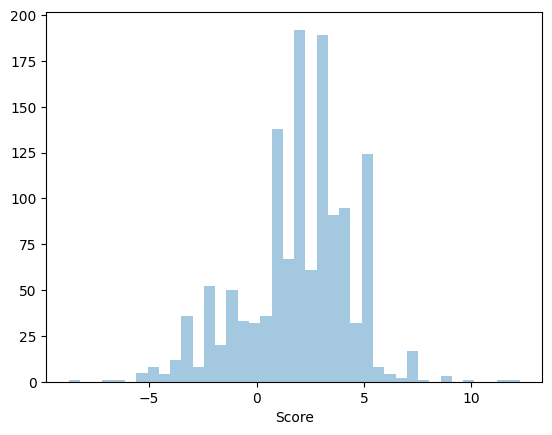

In [84]:
import seaborn as sns
sns.distplot(dfTrain1[(dfTrain1.Score!= 'none') & (dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100)]['Score'], kde=False, bins = 40)

<Axes: xlabel='UpdatedScore'>

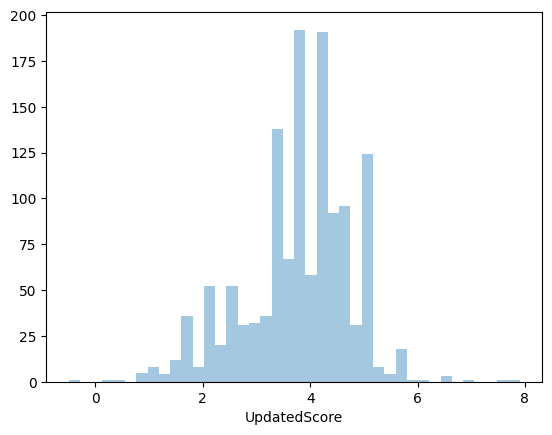

In [85]:
sns.distplot(dfTrain1[(dfTrain1.Score!= 'none') & (dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100)]['UpdatedScore'], kde=False, bins = 40)

### Save Sentiment Analysis Results Files

In [87]:
file_name = "Tweets_English_" + mode + ".xlsx"
dfTrain1.to_excel("/sentiment-analysis-results/"+file_name)

In [88]:
print("Output file save successfully..!")

Output file save successfully..!
